In [2]:
# Imports and Configuration
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import pennylane as qml
import optax
import time
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy.io import loadmat
from scipy import optimize
from scipy.interpolate import griddata, RegularGridInterpolator
from jax.flatten_util import ravel_pytree
import os

jax.config.update("jax_enable_x64", False)
#print(f"JAX version: {jax.__version__}")
#print(f"Available devices: {jax.devices()}")

## Cylinder wake dataset (Raissi et al.)

### Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. *Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Journal of Computational Physics, 378, 686-707*.
### https://github.com/maziarraissi/PINNs

---
- 2D, incompressible flow governed by the Navier–Stokes equations  
  $ \partial_t \mathbf{u} + (\mathbf{u}\cdot\nabla)\mathbf{u}
   = -\nabla p + \nu \nabla^2 \mathbf{u},\ \nabla\cdot\mathbf{u}=0 $.
---
- Non-dimensionalization:
  - Cylinder diameter $D = 1$  
  - Inflow speed $U_\infty\ = 1$  
  - Kinematic viscosity $\nu = 0.01$  $\Rightarrow$ Reynolds number $Re = 100$.
---
- Boundary conditions:
  - **Inflow (left):** Dirichlet $u = 1,\ v = 0$  
  - **Cylinder surface:** $u = v = 0$  
  - **Top/bottom:** Neumann $\partial_n u = \partial_n v = \partial_n p = 0$  
  - **Outflow (right):** Neumann $\partial_n u = \partial_n v = \partial_n p = 0$.
---
- Flow regime: laminar vortex shedding (von Kármán street).
---
- Data:
  - Velocity $U_\star(x,y,t) = [u(x,y,t), v(x,y,t)]$ and pressure $p_\star(x,y,t)$.  
  - High-fidelity simulation using a Nektar++.  
  - All fields are given at fixed spatial sample points $X_\star$ over multiple time snapshots $t_\star$.

In [6]:
def load_cylinder_wake(mat_path="data/cylinder_wake.mat"):

    # Load raw data from the .mat file
    data = loadmat(mat_path)

    U_star = data["U_star"]   # (N, 2, T): velocity [u, v]
    P_star = data["p_star"]   # (N, T): pressure
    t_star = data["t"]        # (T, 1): time
    X_star = data["X_star"]   # (N, 2): spatial coords [x, y]

    N = X_star.shape[0]       # number of spatial points
    T = t_star.shape[0]       # number of time snapshots

    # Build flattened space time coordinates.
    x_all = np.repeat(X_star[:, 0], T).reshape(-1, 1)     # (N*T, 1)
    y_all = np.repeat(X_star[:, 1], T).reshape(-1, 1)     # (N*T, 1)
    t_all = np.tile(t_star.ravel(), N).reshape(-1, 1)     # (N*T, 1)

    # Flatten velocity and pressure fields to match the same order.
    u_all = U_star[:, 0, :].reshape(-1, 1)   # (N*T, 1)
    v_all = U_star[:, 1, :].reshape(-1, 1)   # (N*T, 1)
    p_all = P_star.reshape(-1, 1)            # (N*T, 1)

    # grid information 
    x_unique = np.unique(X_star[:, 0])
    y_unique = np.unique(X_star[:, 1])
    Nx, Ny = x_unique.size, y_unique.size

    return {
        "x_all": x_all, "y_all": y_all, "t_all": t_all,
        "u_all": u_all, "v_all": v_all, "p_all": p_all,
        "U_star": U_star, "P_star": P_star, "X_star": X_star,
        "t_star": t_star, "N": N, "T": T, "Nx": Nx, "Ny": Ny,
        "x_unique": x_unique, "y_unique": y_unique,
    }

data = load_cylinder_wake()

In [4]:
def summarize_cylinder_data(data):
    """Pretty-print a short summary of the cylinder_wake dataset."""
    x_min, x_max = data["x_unique"].min(), data["x_unique"].max()
    y_min, y_max = data["y_unique"].min(), data["y_unique"].max()
    t_min, t_max = data["t_star"].min(), data["t_star"].max()

    N, T = data["N"], data["T"]
    Nx, Ny = data["Nx"], data["Ny"]
    NT = data["x_all"].shape[0]

    print("=== Cylinder wake dataset (Raissi et al.) ===")
    print(f"Spatial domain :  x ∈ [{x_min:6.2f}, {x_max:6.2f}]"
          f",  y ∈ [{y_min:6.2f}, {y_max:6.2f}]")
    print(f"Time interval  :  t ∈ [{t_min:6.2f}, {t_max:6.2f}]")
    print()
    print(f"Grid (x × y)   :  {Nx:d} × {Ny:d} spatial points")
    print(f"Points per t   :  {N:d} (N = Nx × Ny)")
    print(f"Time steps     :  {T:d}")
    print(f"Total samples  :  {NT:,d} space–time points")
    print("Fields         :  u(x,y,t), v(x,y,t), p(x,y,t)")

summarize_cylinder_data(data)

=== Cylinder wake dataset (Raissi et al.) ===
Spatial domain :  x ∈ [  1.00,   8.00],  y ∈ [ -2.00,   2.00]
Time interval  :  t ∈ [  0.00,  19.90]

Grid (x × y)   :  100 × 50 spatial points
Points per t   :  5000 (N = Nx × Ny)
Time steps     :  200
Total samples  :  1,000,000 space–time points
Fields         :  u(x,y,t), v(x,y,t), p(x,y,t)


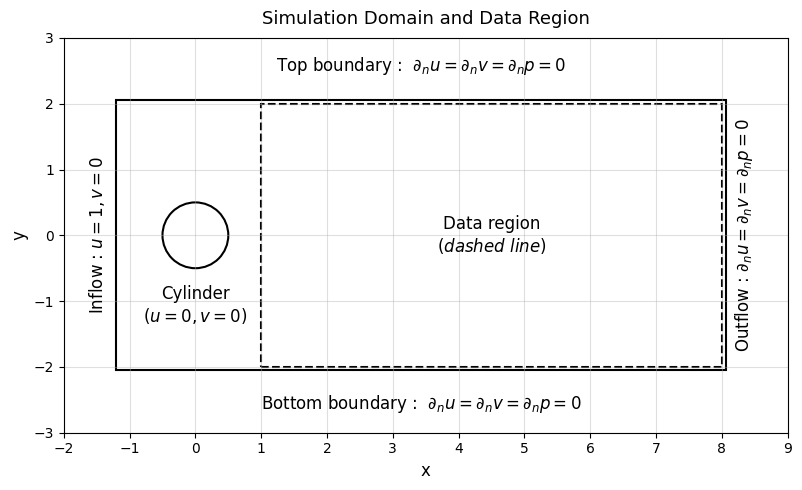

In [5]:
from matplotlib.patches import Rectangle, Circle

def plot_cylinder_wake_domain_with_data_region(data):
    X = data["X_star"]
    # true data region from X_star 
    x_min_data, x_max_data = X[:, 0].min(), X[:, 0].max()
    y_min_data, y_max_data = X[:, 1].min(), X[:, 1].max()
    
    # Cylinder (Raissi setup: center at (0,0), D=1 -> r=0.5)
    cyl_center = (0.0, 0.0)
    cyl_radius = 0.5
    
    # simulation domain: contains cylinder + data region + padding 
    x_min_sim = min(x_min_data, cyl_center[0] - 2.0 * cyl_radius) - 0.2
    x_max_sim = x_max_data + 0.06
    y_min_sim = min(y_min_data, cyl_center[1] - 2.0 * cyl_radius) - 0.05
    y_max_sim = max(y_max_data, cyl_center[1] + 2.0 * cyl_radius) + 0.05
    
    dx, dy = x_max_sim - x_min_sim, y_max_sim - y_min_sim
    y_mid = 0.5 * (y_min_sim + y_max_sim)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_aspect("equal")
    
    # outer simulation domain (solid)
    sim_domain = Rectangle(
        (x_min_sim, y_min_sim), dx, dy,
        fill=False, linewidth=1.5, edgecolor='black'
    )
    ax.add_patch(sim_domain)
    
    # inner data region (dashed, true bounds)
    data_domain = Rectangle(
        (x_min_data, y_min_data), x_max_data - x_min_data, y_max_data - y_min_data,
        fill=False, linestyle="--", linewidth=1.5, edgecolor='black'
    )
    ax.add_patch(data_domain)
    
    # cylinder
    cylinder = Circle(cyl_center, radius=cyl_radius, fill=False, linewidth=1.5, edgecolor='black')
    ax.add_patch(cylinder)
    
    # labels
    ax.text( x_min_sim - 0.45 , y_mid, "Inflow : $u=1, v=0$", ha="left", va="center", rotation=90, fontsize=12
    )
    
    ax.text( x_max_sim + 0.45, y_mid, "Outflow : $\\partial_n u = \\partial_n v = \\partial_n p = 0$",
        ha="right", va="center", rotation=90, fontsize=12
    )
    
    x_mid = 0.5 * (x_min_sim + x_max_sim)
    ax.text(
        x_mid, y_max_sim + 0.35,
        "Top boundary :  $\\partial_n u = \\partial_n v = \\partial_n p = 0$",
        ha="center", va="bottom", fontsize=12
    )
    ax.text(
        x_mid, y_min_sim - 0.35,
        "Bottom boundary :  $\\partial_n u = \\partial_n v = \\partial_n p = 0$",
        ha="center", va="top", fontsize=12
    )
    
    ax.text( cyl_center[0], cyl_center[1] - cyl_radius - 0.25,
        "Cylinder\n($u=0, v=0$)", ha="center", va="top", fontsize=12
    )
    
    ax.text(
        x_min_data + 0.5 * (x_max_data - x_min_data), y_mid,
        "Data region\n($dashed~line$)", ha="center", va="center", fontsize=12
    )
    
    ax.set_xlim(x_min_sim - 0.3, x_max_sim + 0.3)
    ax.set_ylim(y_min_sim - 0.6, y_max_sim + 0.6)
    
    xticks = np.arange(np.floor(x_min_sim), np.ceil(x_max_sim) + 1)
    yticks = np.arange(np.floor(y_min_sim), np.ceil(y_max_sim) + 1)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_title("Simulation Domain and Data Region", fontsize=13, pad=10)
    ax.grid(alpha=0.4)
    
    plt.tight_layout()
    plt.show()

plot_cylinder_wake_domain_with_data_region(data)

In [7]:
# Sampling
def sample_training(data, frac=0.005, seed=0):
    # randomly sample a subset of space time points from the full dataset.

    x_all, y_all, t_all = data["x_all"], data["y_all"], data["t_all"]
    u_all, v_all, p_all = data["u_all"], data["v_all"], data["p_all"]
    
    # total number of space-time points (N*T)
    NT = x_all.shape[0]

    # number of points to sample 
    samples = int(round(NT * frac))

    # fixed seed for reproduciblity
    np.random.seed(seed)

    # randomly distint indices
    idx = np.random.choice(NT, samples, replace=False)
    
    # single coordinates array [x, y, t] of shape: (samples, 3)
    xyt = np.hstack([x_all[idx], y_all[idx], t_all[idx]]).astype(np.float32)
    
    # single fields array [u, v, p] of shape: (samples, 3)
    uvp = np.hstack([u_all[idx], v_all[idx], p_all[idx]]).astype(np.float32)

    return {"xyt": xyt, "uvp": uvp, "idx": idx}

# Load and sample data
train = sample_training(data, frac=0.005, seed=0)
xyt_train, uvp_train = train["xyt"], train["uvp"]

print(f"Number of samples in the training data: {xyt_train.shape[0]:,}")

Number of samples in the training data: 5,000


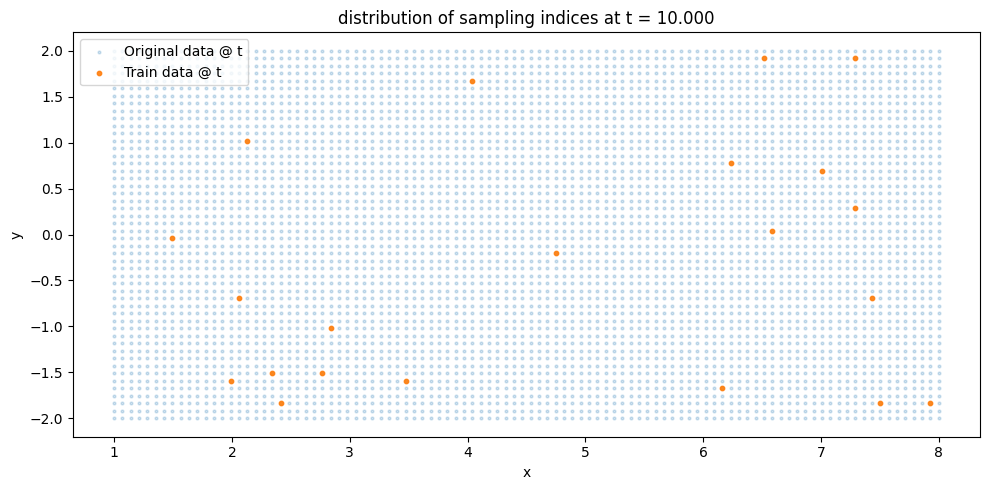

In [8]:
t_index = 100  # t_index in [0,data["T"])
t_slice = data["t_star"][t_index, 0]  

t_all_flat = data["t_all"].ravel()
mask_all = np.isclose(t_all_flat, t_slice)

t_train_flat = xyt_train[:, 2]
mask_train = np.isclose(t_train_flat, t_slice)

plt.figure(figsize=(10, 5))
plt.scatter(data["x_all"][mask_all], data["y_all"][mask_all], 
            s=4, alpha=0.2, label="Original data @ t")
plt.scatter(xyt_train[mask_train, 0], xyt_train[mask_train, 1],
            s=10, alpha=0.9, label="Train data @ t")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"distribution of sampling indices at t = {t_slice:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Helper to animate vorticity (original data vs sampling)
def animate_vorticity_truth_vs_samples(data, train, t_indices=None, interval=100):
    # comparison of ground-truth vorticity field vs. sparse training samples.

    X_star = data["X_star"]    # (N, 2)
    U_star = data["U_star"]    # (N, 2, T)
    t_star = data["t_star"][:, 0]  # (T,)
    x_unique = data["x_unique"]
    y_unique = data["y_unique"]

    xyt_train = train["xyt"]   # (samples, 3) [x, y, t]

    T = t_star.shape[0]

    # Build regular grid from unique x,y
    xg, yg = np.meshgrid(x_unique, y_unique)  # shape (Ny, Nx)
    dx = np.mean(np.diff(x_unique))
    dy = np.mean(np.diff(y_unique))

    if t_indices is None:
        t_indices = list(range(0, int(T), max(1, int(T // 50))))

    def vorticity_on_grid(ti):
        u = U_star[:, 0, ti]  # (N,)
        v = U_star[:, 1, ti]  # (N,)

        u_grid = griddata((X_star[:, 0], X_star[:, 1]), u, (xg, yg), method="cubic")
        v_grid = griddata((X_star[:, 0], X_star[:, 1]), v, (xg, yg), method="cubic")

        du_dy, du_dx = np.gradient(u_grid, dy, dx, edge_order=2)
        dv_dy, dv_dx = np.gradient(v_grid, dy, dx, edge_order=2)

        omega = dv_dx - du_dy  # scalar vorticity
        return omega

    vmin, vmax = np.inf, -np.inf
    for ti in t_indices:
        omega = vorticity_on_grid(ti)
        vmin = min(vmin, np.nanmin(omega))
        vmax = max(vmax, np.nanmax(omega))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    ti0 = t_indices[0]
    t0 = float(t_star[ti0])
    omega0 = vorticity_on_grid(ti0)

    # left: full vorticity field
    im = axes[0].imshow(
        omega0,
        origin="lower",
        cmap="RdBu_r",
        extent=[xg.min(), xg.max(), yg.min(), yg.max()],
        vmin=vmin, vmax=vmax,
    )
    axes[0].set_title("Vorticity (original data)", fontsize=12)
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Right: vorticity at sampled points for t0
    mask0 = np.isclose(xyt_train[:, 2], t0, atol=1e-8)
    xy0 = xyt_train[mask0, :2]

    interp0 = RegularGridInterpolator(
        (y_unique, x_unique),  # (row = y, col = x)
        omega0,
        bounds_error=False,
        fill_value=np.nan,
    )
    omega_samples0 = interp0(np.column_stack([xy0[:, 1], xy0[:, 0]]))  # (y, x)

    scat = axes[1].scatter(
        xy0[:, 0],
        xy0[:, 1],
        c=omega_samples0,
        cmap="RdBu_r",
        vmin=vmin, vmax=vmax,
        s=20,
        edgecolors="k",
        linewidths=0.3,
    )
    axes[1].set_title("Sampled Vorticity (training indices)",
                      fontsize=12)
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    axes[1].set_xlim(xg.min(), xg.max())
    axes[1].set_ylim(yg.min(), yg.max())

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    cbar = fig.colorbar(im, ax=axes, orientation="vertical", pad=0.02, aspect=30)
    cbar.set_label("Vorticity ω", fontsize=12)

    def update(frame_idx):
        ti = t_indices[frame_idx]
        t_val = float(t_star[ti])
        omega = vorticity_on_grid(ti)
        im.set_data(omega)

        mask = np.isclose(xyt_train[:, 2], t_val, atol=1e-8)
        xy = xyt_train[mask, :2]

        if np.any(mask):
            interp = RegularGridInterpolator(
                (y_unique, x_unique),
                omega,
                bounds_error=False,
                fill_value=np.nan,
            )
            omega_samples = interp(np.column_stack([xy[:, 1], xy[:, 0]]))

            scat.set_offsets(xy)
            scat.set_array(omega_samples)
        else:
            # no samples at this time step
            scat.set_offsets(np.empty((0, 2)))
            scat.set_array(np.array([]))

        fig.suptitle(
            f"Vorticity @ t = {t_val:.4f} (step {ti}/{T})",
            fontsize=14,
        )
        return [im, scat]

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=len(t_indices),
        interval=interval,
        blit=False,
    )
    plt.close(fig) 
    return fig, anim

In [10]:
t_indices = list(range(0, int(data["T"]), max(1, int(data["T"] // 40))))

fig_anim, anim = animate_vorticity_truth_vs_samples(
    data=data,
    train=train,
    t_indices=t_indices,
    interval=100,
)

from IPython.display import HTML
HTML(anim.to_jshtml())

### Physics-Informed Loss Function

We train the network $ \text{net\_fn}(x, y, t; \theta) \rightarrow (u, v, p) $ by minimizing a combined **data + physics loss**:

$
\mathcal{L}(\theta) = \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{PDE}}.
$

**1. Data loss**

The data loss enforces agreement with observed velocity and pressure at sampled points $(x_i, y_i, t_i)$:

$
\mathcal{L}_{\text{data}} =
\frac{1}{N} \sum_{i=1}^{N}
\Big[
(u_\theta^i - u_i)^2 +
(v_\theta^i - v_i)^2 +
(p_\theta^i - p_i)^2
\Big].
$

**2. PDE residual loss**

The physics loss penalizes violations of the 2D incompressible Navier–Stokes equations:

- x-momentum residual $f$
- y-momentum residual $g$
- continuity residual $h$

$
\mathcal{L}_{\text{PDE}} =
\frac{1}{N} \sum_{i=1}^{N}
\Big[
f_\theta(x_i, y_i, t_i)^2 +
g_\theta(x_i, y_i, t_i)^2 +
h_\theta(x_i, y_i, t_i)^2
\Big].
$

Here, the residuals are computed from automatic differentiation of the network output:

$
\begin{aligned}
f &= u_t + u u_x + v u_y + \frac{1}{\rho} p_x - \nu (u_{xx} + u_{yy}), \\
g &= v_t + u v_x + v v_y + \frac{1}{\rho} p_y - \nu (v_{xx} + v_{yy}), \\
h &= u_x + v_y.
\end{aligned}
$

This loss makes the neural network **fit the data** while also being **constrained by the Navier–Stokes physics**, which acts as a strong regularizer.

In [11]:
# Physics-Informed Loss for 2D Incompressible Navier–Stokes (x, y, t)

nu = 0.01  # kinematic viscosity
rho = 1.0  # density

def residuals_single(params, z, nu, rho, net_fn):
    
    # Compute Navier–Stokes residuals at a single spatio-temporal point z = [x, y, t].

    # wrappers to extract u, v, p from the network output
    u_fn = lambda zz: net_fn(params, zz)[0]
    v_fn = lambda zz: net_fn(params, zz)[1]
    p_fn = lambda zz: net_fn(params, zz)[2]

    # first derivatives wrt [x, y, t]
    du = jax.grad(u_fn)(z)  # [u_x, u_y, u_t]
    dv = jax.grad(v_fn)(z)  # [v_x, v_y, v_t]
    dp = jax.grad(p_fn)(z)  # [p_x, p_y, p_t]

    # Second derivatives using Hessians
    Hu = jax.hessian(u_fn)(z)  # Hu[i, j] = ∂²u / (∂z_i ∂z_j)
    Hv = jax.hessian(v_fn)(z)  # Hv[i, j] = ∂²v / (∂z_i ∂z_j)

    # field values at z
    u, v, p = net_fn(params, z)

    # unpack derivatives
    u_x, u_y, u_t = du[0], du[1], du[2]
    v_x, v_y, v_t = dv[0], dv[1], dv[2]
    p_x, p_y      = dp[0], dp[1]

    # Laplacians in x, y (ignoring second derivatives in time)
    u_xx, u_yy = Hu[0, 0], Hu[1, 1]
    v_xx, v_yy = Hv[0, 0], Hv[1, 1]

    # Navier–Stokes residuals
    # x-momentum residual
    f = u_t + u * u_x + v * u_y + (1.0 / rho) * p_x - nu * (u_xx + u_yy)
    # y-momentum residual
    g = v_t + u * v_x + v * v_y + (1.0 / rho) * p_y - nu * (v_xx + v_yy)
    # Continuity residual (incompressibility)
    h = u_x + v_y

    return f, g, h


# Vectorized residuals over a batch of [x, y, t] points
residuals_batch = vmap(residuals_single, in_axes=(None, 0, None, None, None))


def uvp_batch(params, xyt, net_fn):
    # Batch prediction of (u, v, p) at a set of spatio-temporal points.
    
    def single_pred(z):
        u, v, p = net_fn(params, z)
        return u, v, p

    u_batch, v_batch, p_batch = vmap(single_pred)(xyt)
    return u_batch, v_batch, p_batch


def loss_fn(params, xyt, uvp_true, nu, rho, net_fn):
    # Compute total PINN loss = data loss + PDE residual loss.

    # Data fidelity term
    u_pred, v_pred, p_pred = uvp_batch(params, xyt, net_fn)

    L_data_u = jnp.mean((u_pred - uvp_true[:, 0]) ** 2)
    L_data_v = jnp.mean((v_pred - uvp_true[:, 1]) ** 2)
    L_data_p = jnp.mean((p_pred - uvp_true[:, 2]) ** 2)
    L_data = L_data_u + L_data_v + L_data_p

    # PDE residual penalty
    f, g, h = residuals_batch(params, xyt, nu, rho, net_fn)

    L_pde_f = jnp.mean(f ** 2)
    L_pde_g = jnp.mean(g ** 2)
    L_pde_h = jnp.mean(h ** 2)
    L_pde = L_pde_f + L_pde_g + L_pde_h

    # Total loss
    total_loss = L_data + L_pde

    return {
        "total": total_loss,
        "L_data": L_data,
        "L_pde": L_pde,
        "mean_abs_f": jnp.mean(jnp.abs(f)),
        "mean_abs_g": jnp.mean(jnp.abs(g)),
        "mean_abs_h": jnp.mean(jnp.abs(h)),
    }

print("Physics-informed loss function defined ✓")
print(f"Parameters: ν = {nu}, ρ = {rho}")

Physics-informed loss function defined ✓
Parameters: ν = 0.01, ρ = 1.0


## Total Complexity Per Training Step (PINN)

For a Physics-Informed Neural Network computing Navier-Stokes residuals with:
- Batch size $B$
- Input dimension $d = 3$ (x, y, t)
- Output dimension $m = 3$ (u, v, p)
- Base forward pass cost $C_{\text{forward}}$

The total computational cost per training step is:

$
T_{\text{PINN}} = O\Big(B \cdot (1 + md + 2d^2) \cdot C_{\text{forward}} \Big)
$

For your specific case ($d = 3$, $m = 3$):

$
T_{\text{PINN}} = O\Big(28B \cdot C_{\text{forward}} \Big)
$

**Breakdown:**
- **1** forward pass for prediction (`uvp_batch`)
- **$md = 9$** forward passes for first derivatives (m outputs × d inputs via `jax.grad`)
- **$2d^2 = 18$** forward passes for second derivatives (2 Hessians for u, v; each Hessian is $d \times d$)

**Note:** The factor $2d^2$ comes from computing Hessians for only u and v (not p), where each Hessian requires $d$ gradient computations, each of which requires $d$ forward passes.

# Classical PINN
### Reference: https://github.com/Matt2371/PINN_navier_stokes/
[pytorch]

## Defining the classical Neural Network Architecture

To approximate the flow field $(u, v, p)$, we use a fully-connected multilayer perceptron (MLP) that maps the input coordinates  
$
(x, y, t) \;\longrightarrow\; (u, v, p).
$

---

### Glorot Initialization
#### Xavier Glorot & Yoshua Bengio, “Understanding the Difficulty of Training Deep Feedforward Neural Networks” (AISTATS 2010).

Glorot initialization sets the weights of each layer using
$
W \sim \mathcal{U}\!\left[-\sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}},
\;\sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}\right],
$

where $n_{\text{in}}$ and $n_{\text{out}}$ are the input and output dimensions of the layer.  

This ensures:
   - Input and output of each layer have the same expected variance
   - Avoids vanishing/exploding gradients
   - Makes training smoother and faster
    
---

### Layer structure

The architecture is intentionally simple and physics-friendly:

1. **First layer — sinusoidal activation**  
   - The first hidden layer applies: $ z_1 = \sin(2\pi (W_1 x + b_1))$.
   - Using a sinusoidal activation improves the network’s ability to represent  
   multi-scale and oscillatory flow structures.

2. **Hidden layers — tanh activation**  
   - The remaining hidden layers use: $ z_{k+1} = \tanh(W_k z_k + b_k) $
   - The smoothness of $\tanh$ helps produce differentiable outputs, a key requirement for  
   PINNs since automatic differentiation is used to compute PDE residuals.

3. **Output layer — linear**  
   - $ (u, v, p) = W_\text{out} z_L + b_\text{out} $
   - No activation is applied in the final layer, allowing the network to freely represent  
   the velocity and pressure fields.

---

### Summary

This classical MLP provides a differentiable function  
$ f_\theta(x, y, t) = (u_\theta, v_\theta, p_\theta) $
with smooth derivatives suitable for computing Navier–Stokes PDE residuals.

In [12]:
# Classical Neural Network Architecture

def glorot_init(rng, in_dim, out_dim):
    # Xavier/Glorot initialization
    limit = jnp.sqrt(6.0 / (in_dim + out_dim))
    W = jax.random.uniform(rng, (in_dim, out_dim), minval=-limit, maxval=limit)
    b = jnp.zeros((out_dim,))
    return W, b

def init_classical_params(rng, in_dim, hidden_size, num_layers, out_dim):
    # Initialize classical MLP: sin activation on first layer, tanh on hidden
    params = []
    
    # First layer
    key0, rng = jax.random.split(rng)
    W0, b0 = glorot_init(key0, in_dim, hidden_size)
    params.append({"W": W0, "b": b0})
    
    # Hidden layers
    for _ in range(num_layers - 2):
        keyh, rng = jax.random.split(rng)
        Wh, bh = glorot_init(keyh, hidden_size, hidden_size)
        params.append({"W": Wh, "b": bh})
    
    # Output layer
    keyo, rng = jax.random.split(rng)
    Wo, bo = glorot_init(keyo, hidden_size, out_dim)
    params.append({"W": Wo, "b": bo})
    
    return params

def classical_network(params, x):
    # Forward pass: (x, y, t) -> (u, v, p)
    # First layer with sin activation
    z = x @ params[0]["W"] + params[0]["b"]
    z = jnp.sin(2.0 * jnp.pi * z)
    
    # Hidden layers with tanh
    for layer in params[1:-1]:
        z = jnp.tanh(z @ layer["W"] + layer["b"])
    
    # Output layer (linear)
    out = z @ params[-1]["W"] + params[-1]["b"]
    return out  # (u, v, p)

print("Classical network architecture defined ✓")

Classical network architecture defined ✓


## Complexity of the classical network

---

### Parameter Count

For an MLP with:
- input dimension `in_dim`
- hidden width `h = hidden_size`
- total layers `L = num_layers`
- output dimension `out_dim`

The total number of trainable parameters is:

$
N_{\text{params}} = in\_dim \cdot h + h + (L - 2)(h^2 + h) + h \cdot out\_dim + out\_dim
$

**Breakdown:**
- **Input → hidden layer:** $in\_dim \cdot h + h$ (weights + biases)
- **Hidden layers (there are $L - 2$):** $(h^2 + h)(L - 2)$ (each has $h^2$ weights + $h$ biases)
- **Hidden → output layer:** $h \cdot out\_dim + out\_dim$ (weights + biases)

---

### Forward Pass Complexity

For batch size $B$, the computational cost of one forward pass is:

$
T_{\text{forward}} = O\Big(B \cdot \left[in\_dim \cdot h + (L - 2)h^2 + h \cdot out\_dim \right] \Big)
$

**Breakdown:**
- Input → first hidden: $O(B \cdot in\_dim \cdot h)$
- Hidden → hidden ($L-2$ layers): $O(B \cdot (L-2) \cdot h^2)$
- Last hidden → output: $O(B \cdot h \cdot out\_dim)$

Nonlinearities (sin, tanh) contribute $O(Bh)$ per layer and are negligible compared to matrix multiplications.

# Hybrid (Quantum + Classical) PINN 
### Reference: https://github.com/andreazingarofalo/QPINNs/
#### 1D spring-mass-damper differential equation
[tensorflow + pennylane]

In [13]:
# Quantum Circuit Setup

# Quantum configuration
n_qubits = 4
n_layers = 4

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='jax', diff_method='best')
def qnode(inputs, weights):
    """Quantum circuit with angle embedding and entangling layers"""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

weight_shape = qml.StronglyEntanglingLayers.shape(n_layers, n_qubits)

print(f"Quantum device: {n_qubits} qubits, {n_layers} layers")
print(f"Weight shape: {weight_shape}")

Quantum device: 4 qubits, 4 layers
Weight shape: (4, 4, 3)


## Quantum Layer Architecture

This code defines a **parameterized quantum circuit** that serves as the core quantum layer in the hybrid quantum-classical neural network.

--- 

### Circuit Components

1. **Device Setup**
   - Uses PennyLane's `default.qubit` simulator with `n_qubits = 4` qubits
   - Integrated with JAX for automatic differentiation (`interface='jax'`)

2. **Input Encoding: `AngleEmbedding`**
   - Encodes classical input data into quantum states
   - Maps each input value to a rotation angle on its corresponding qubit
   - Specifically applies $R_y(\theta_i)$ rotations where $\theta_i$ is the $i$-th input

3. **Parameterized Quantum Layers: `StronglyEntanglingLayers`**
   - Applies `n_layers = 4` layers of trainable quantum gates
   - Each layer contains:
     - Single-qubit rotations: $R_x(\theta)$, $R_y(\phi)$, $R_z(\omega)$ on each qubit (3 parameters per qubit)
     - Two-qubit entangling gates (CNOT) between adjacent qubits
   - Creates quantum entanglement, allowing qubits to influence each other ( A 4-qubit entangled state lives in a $2^4 = 16$-dimensional Hilbert space )
   - Total trainable parameters: $3 \times n_{\text{qubits}} \times n_{\text{layers}} = 3 \times 4 \times 4 = 48$

4. **Measurement**
   - Measures the expected value of the Pauli-Z operator ($\langle Z \rangle$) on each qubit
   - Returns `n_qubits = 4` real-valued outputs in the range $[-1, 1]$
   - These outputs are then fed into classical postprocessing layers

---

### Key Properties

- **Trainable parameters:** The `weights` in `StronglyEntanglingLayers` are optimized via gradient descent
- **Quantum advantage (in theory):** Entanglement allows the circuit to capture correlations that might be expensive for classical networks
- **Automatic differentiation:** PennyLane computes gradients of quantum circuit outputs w.r.t. parameters using the parameter-shift rule

## Defining the Hybrid Quantum-Classical Architecture

To approximate the flow field $(u, v, p)$, we use a hybrid quantum-classical network that combines classical preprocessing layers, a parameterized quantum circuit (PQC), and classical postprocessing layers to map the input coordinates  

$
(x, y, t) \;\longrightarrow\; (u, v, p).
$

---

### Input Normalization

Before entering the network, the spatio-temporal coordinates are normalized to $[0,1]$:

$
\tilde{x} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}, \quad
\tilde{y} = \frac{y - y_{\min}}{y_{\max} - y_{\min}}, \quad
\tilde{t} = \frac{t - t_{\min}}{t_{\max} - t_{\min}}.
$

This normalization stabilizes training and ensures that quantum encoding operates on a well-conditioned input domain.

---

### Architecture Variants

We implement two hybrid architectures with increasing expressivity:

#### **Architecture 1: Simple Hybrid**

$
[3] \;\xrightarrow{\text{Dense}(n_q)}\; [n_q] \;\xrightarrow{\text{Quantum}}\; [n_q] \;\xrightarrow{\text{Dense}(3)}\; [3]
$

**Layer structure:**
1. **Classical preprocessing with Fourier features**  
   - $h_1 = \sin(2\pi (W_1 \tilde{x} + b_1))$, where $W_1 \in \mathbb{R}^{3 \times n_q}$
   - Sinusoidal activation encodes multi-scale spatial and temporal features, improving the network's ability to represent oscillatory patterns in the flow field.

2. **Quantum layer**  
   - The classical features $h_1$ are encoded into a $n_q$-qubit parameterized quantum circuit with $n_L$ layers.
   - The quantum circuit applies rotation and entanglement gates controlled by learnable parameters $\theta_{\text{quantum}}$.
   - Measurement expectation values produce quantum outputs: $q_{\text{out}} \in \mathbb{R}^{n_q}$.

3. **Classical postprocessing — linear**  
   - $(u, v, p) = W_2 \, q_{\text{out}} + b_2$, where $W_2 \in \mathbb{R}^{n_q \times 3}$
   - No activation is applied, allowing free representation of the velocity and pressure fields.

---

#### **Architecture 2: Deep Hybrid**

$
[3] \;\xrightarrow{\text{Dense}(16)}\; [16] \;\xrightarrow{\text{Dense}(n_q)}\; [n_q] \;\xrightarrow{\text{Quantum}}\; [n_q] \;\xrightarrow{\text{Dense}(16)}\; [16] \;\xrightarrow{\text{Dense}(3)}\; [3]
$

**Layer structure:**
1. **Classical preprocessing — two-layer network**  
   - First layer: $h_1 = \sin(2\pi (W_1 \tilde{x} + b_1))$, where $W_1 \in \mathbb{R}^{3 \times 16}$
   - Second layer: $h_2 = \tanh(W_2 h_1 + b_2)$, where $W_2 \in \mathbb{R}^{16 \times n_q}$
   - The additional hidden layer increases representational capacity before quantum encoding.

2. **Quantum layer**  
   - Same parameterized quantum circuit as Architecture 1.
   - Measurement yields $q_{\text{out}} \in \mathbb{R}^{n_q}$.

3. **Classical postprocessing — two-layer network**  
   - First layer: $h_3 = \tanh(W_3 q_{\text{out}} + b_3)$, where $W_3 \in \mathbb{R}^{n_q \times 16}$
   - Output layer: $(u, v, p) = W_4 h_3 + b_4$, where $W_4 \in \mathbb{R}^{16 \times 3}$
   - The deeper postprocessing allows more flexible transformation of quantum features into physical outputs.

---

### Weight Initialization

**Classical layers:**  
- Input and hidden layers use He initialization: $W \sim \mathcal{N}(0, \sqrt{2/n_{\text{in}}})$
- Promotes stable gradient flow in networks with ReLU-like activations.

**Quantum layer:**  
- Parameters initialized from a small-variance normal distribution: $\theta_{\text{quantum}} \sim \mathcal{N}(0, 0.01)$
- Small initial values prevent the quantum circuit from saturating in highly entangled states early in training.

---

### Quantum Circuit Design (recap)

The parameterized quantum circuit consists of:
- **Amplitude encoding:** Classical features $h$ are encoded into qubit amplitudes.
- **Variational layers:** Each layer applies single-qubit rotations $R_y(\theta)$ followed by entangling gates (e.g., CNOT rings).
- **Measurement:** Pauli-Z expectation values are measured on each qubit to extract $n_q$ classical features.

---

### Summary

The hybrid quantum-classical architecture provides a differentiable function  

$
f_{\theta}(x, y, t) = (u_{\theta}, v_{\theta}, p_{\theta})
$

where $\theta$ includes both classical weights and quantum circuit parameters.
- Classical Fourier features for multi-scale encoding,
- Quantum circuits for expressive non-linear transformations, and
- Classical postprocessing for physical output generation

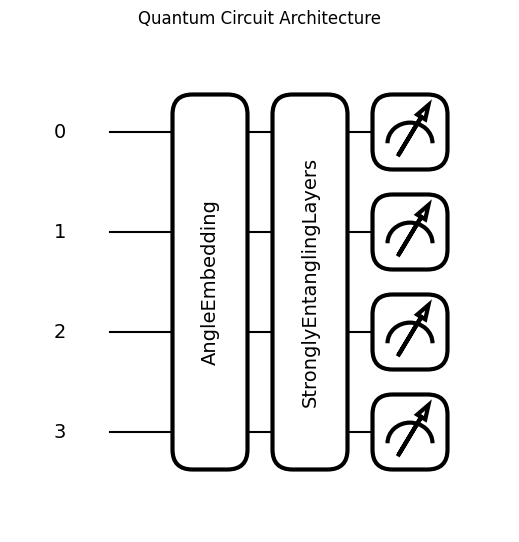

In [14]:
# Visualize circuit
#inputs_sample = np.array([0.1, 0.2, 0.3, 0.4])
inputs_sample = np.linspace(0.1, 0.8, n_qubits)

weights_sample = np.random.randn(*weight_shape) * 0.1

fig, ax = qml.draw_mpl(qnode)(inputs_sample, weights_sample)
plt.title("Quantum Circuit Architecture")
#plt.tight_layout()
plt.show()

In [16]:
# Multiple Hybrid Architectures

# ==================== Architecture 1: Original (Simple) ====================
# Input normalization helpers (map x,y,t to [0,1])
x_min, x_max = float(data['x_unique'].min()), float(data['x_unique'].max())
y_min, y_max = float(data['y_unique'].min()), float(data['y_unique'].max())
t_min, t_max = float(data['t_star'].min()), float(data['t_star'].max())
norm_off = jnp.array([x_min, y_min, t_min], dtype=jnp.float32)
norm_scale01 = jnp.array([1.0/(x_max - x_min + 1e-12), 1.0/(y_max - y_min + 1e-12), 1.0/(t_max - t_min + 1e-12)], dtype=jnp.float32)
def normalize01(z):
    return (z - norm_off) * norm_scale01

def init_quantum_params_original(key, n_qubits, n_layers):
    # Original simple quantum architecture
    keys = jax.random.split(key, 3)
    
    # Classical layer 1: 3 -> n_qubits
    w1 = jax.random.normal(keys[0], (3, n_qubits)) * 0.1
    b1 = jnp.zeros((n_qubits,))
    
    # Quantum layer weights
    q_weights = jax.random.normal(keys[1], weight_shape) * 0.1
    
    # Classical layer 2: n_qubits -> 3
    w2 = jax.random.normal(keys[2], (n_qubits, 3)) * 0.1
    b2 = jnp.zeros((3,))
    
    return {'w1': w1, 'b1': b1, 'q_weights': q_weights, 'w2': w2, 'b2': b2}

def quantum_network_original(params, x):
    # Original simple architecture
    # Classical preprocessing with Fourier features + input normalization
    x01 = normalize01(x)
    h1 = jnp.sin(2.0 * jnp.pi * (x01 @ params['w1'] + params['b1']))
    
    # Quantum layer
    q_out = jnp.array(qnode(h1, params['q_weights']))
    
    # Classical postprocessing
    output = q_out @ params['w2'] + params['b2']
    
    return output

# ==================== Architecture 2: Improved (Deeper Classical) ====================
def init_quantum_params_improved(key, n_qubits, n_layers, hidden_dim=16):
    # Improved architecture with deeper classical layers
    keys = jax.random.split(key, 5)
    
    # Classical preprocessing: 3 -> hidden_dim -> n_qubits
    w1 = jax.random.normal(keys[0], (3, hidden_dim)) * jnp.sqrt(2.0 / 3)
    b1 = jnp.zeros((hidden_dim,))
    
    w2 = jax.random.normal(keys[1], (hidden_dim, n_qubits)) * jnp.sqrt(2.0 / hidden_dim)
    b2 = jnp.zeros((n_qubits,))
    
    # Quantum layer weights
    q_weights = jax.random.normal(keys[2], weight_shape) * 0.01
    
    # Classical postprocessing: n_qubits -> hidden_dim -> 3
    w3 = jax.random.normal(keys[3], (n_qubits, hidden_dim)) * jnp.sqrt(2.0 / n_qubits)
    b3 = jnp.zeros((hidden_dim,))
    
    w4 = jax.random.normal(keys[4], (hidden_dim, 3)) * jnp.sqrt(2.0 / hidden_dim)
    b4 = jnp.zeros((3,))
    
    return {
        'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2,
        'q_weights': q_weights,
        'w3': w3, 'b3': b3, 'w4': w4, 'b4': b4
    }

def quantum_network_improved(params, x):
    # Improved architecture with input normalization and Fourier features
    # Normalize inputs to [0,1]
    x01 = normalize01(x)
    
    # Classical preprocessing with Fourier features
    h1 = jnp.sin(2.0 * jnp.pi * (x01 @ params['w1'] + params['b1']))
    h2 = jnp.tanh(h1 @ params['w2'] + params['b2'])
    
    # Quantum layer
    q_out = jnp.array(qnode(h2, params['q_weights']))
    
    # Classical postprocessing
    h3 = jnp.tanh(q_out @ params['w3'] + params['b3'])
    output = h3 @ params['w4'] + params['b4']
    
    return output

print("Multiple quantum network architectures defined ✓")
print(f"1. Original:      [3] -> Dense({n_qubits}) -> Quantum({n_qubits}q×{n_layers}L) -> [3]")
print(f"2. Improved:      [3] -> Dense(16) -> Dense({n_qubits}) -> Quantum({n_qubits}q×{n_layers}L) -> Dense(16) -> [3]")

Multiple quantum network architectures defined ✓
1. Original:      [3] -> Dense(4) -> Quantum(4q×4L) -> [3]
2. Improved:      [3] -> Dense(16) -> Dense(4) -> Quantum(4q×4L) -> Dense(16) -> [3]


## Complexity of Quantum Neural Networks

### Architecture 1: Original (Simple)
**Structure:** `[3] → Dense(n_qubits) → Quantum(n_qubits q × n_layers L) → Dense(3)`

---

#### Parameter Count

$
N_{\text{params}} = 3 \cdot n_q + n_q + 3n_q \cdot n_L + n_q \cdot 3 + 3
$

**Breakdown:**
- **Classical layer 1:** $3 \cdot n_q + n_q$ (weights + biases)
- **Quantum layer:** $3 \cdot n_q \cdot n_L$ (StronglyEntanglingLayers uses 3 parameters per qubit per layer)
- **Classical layer 2:** $n_q \cdot 3 + 3$ (weights + biases)

**Simplified:**
$
N_{\text{params}} = 4n_q + 3n_qn_L + 3n_q + 3 = n_q(7 + 3n_L) + 3
$

---

#### Forward Pass Complexity

For batch size $B$:

$
T_{\text{forward}} = O\Big(B \cdot [3n_q + 2^{n_q} \cdot n_L + 3n_q] \Big)
$

**Breakdown:**
- **Classical preprocessing:** $O(B \cdot 3n_q)$ (matrix multiplication + sin activation)
- **Quantum circuit:** $O(B \cdot 2^{n_q} \cdot n_L)$ (exponential in number of qubits)
- **Classical postprocessing:** $O(B \cdot 3n_q)$ (matrix multiplication)

**Dominant term:** $O(B \cdot 2^{n_q} \cdot n_L)$ — exponential scaling with qubits

---

### Architecture 2: Improved (Deeper Classical)
**Structure:** `[3] → Dense(h) → Dense(n_qubits) → Quantum(n_qubits q × n_layers L) → Dense(h) → Dense(3)`

where $h = 16$ (hidden dimension)

---

#### Parameter Count

$
N_{\text{params}} = 3h + h + h \cdot n_q + n_q + 3n_qn_L + n_q \cdot h + h + h \cdot 3 + 3
$

**Breakdown:**
- **Classical preprocessing layers:** $3h + h + h \cdot n_q + n_q$
- **Quantum layer:** $3n_qn_L$
- **Classical postprocessing layers:** $n_q \cdot h + h + 3h + 3$

**Simplified:**
$
N_{\text{params}} = 7h + 2n_qh + n_q + 3n_qn_L + 3
$

For $h = 16$:
$
N_{\text{params}} = 112 + 32n_q + 3n_qn_L + n_q + 3 = 115 + 33n_q + 3n_qn_L
$

---

#### Forward Pass Complexity

For batch size $B$:

$
T_{\text{forward}} = O\Big(B \cdot [3h + hn_q + 2^{n_q} \cdot n_L + n_qh + 3h] \Big)
$

**Breakdown:**
- **Classical layer 1:** $O(B \cdot 3h)$
- **Classical layer 2:** $O(B \cdot h \cdot n_q)$
- **Quantum circuit:** $O(B \cdot 2^{n_q} \cdot n_L)$
- **Classical layer 3:** $O(B \cdot n_q \cdot h)$
- **Classical layer 4:** $O(B \cdot 3h)$

**Simplified:**
$
T_{\text{forward}} = O\Big(B \cdot [6h + 2hn_q + 2^{n_q} \cdot n_L] \Big)
$

For $h = 16$:
$
T_{\text{forward}} = O\Big(B \cdot [96 + 32n_q + 2^{n_q} \cdot n_L] \Big)
$

**Dominant term:** $O(B \cdot 2^{n_q} \cdot n_L)$ — exponential scaling with qubits

---

### Key Observations

1. **Exponential scaling:** Both architectures are dominated by the quantum circuit cost $O(2^{n_q} \cdot n_L)$, which grows exponentially with the number of qubits.

2. **Classical overhead:** The improved architecture adds $O(B \cdot hn_q)$ classical computation, which is negligible compared to the quantum circuit for $n_q \geq 4$.

3. **Practical implication:** For $n_q = 4$, the quantum circuit requires simulating a $2^4 = 16$-dimensional state space, making it comparable to a small classical network. The advantage (or disadvantage) becomes dramatic as $n_q$ scales.

In [17]:
# Training Function with L-BFGS/Adam Optimizer

def make_loss_and_grad_fn(net_fn):
    # JIT-compiled loss function for a specific network
    @jit
    def loss_scalar_and_grad(params, xyt, uvp_true, nu, rho):
        def _scalar_loss(pp):
            out = loss_fn(pp, xyt, uvp_true, nu, rho, net_fn)
            return out["total"], out
        (total, parts), grads = jax.value_and_grad(_scalar_loss, has_aux=True)(params)
        return total, parts, grads
    return loss_scalar_and_grad

def train_lbfgs(params, xyt_train, uvp_train, nu, rho, net_fn, maxiter=1000):
    # Train with SciPy L-BFGS-B optimizer
    xyt = jnp.asarray(xyt_train)
    uvp = jnp.asarray(uvp_train)
    
    # Create JIT-compiled loss function for this specific network
    loss_scalar_and_grad = make_loss_and_grad_fn(net_fn)
    
    # Flatten params to 1D vector
    theta0, unravel = ravel_pytree(params)
    
    def objective(theta):
        pp = unravel(theta)
        total, parts, grads = loss_scalar_and_grad(pp, xyt, uvp, nu, rho)
        g_flat, _ = ravel_pytree(grads)
        return float(total), np.asarray(g_flat, dtype=np.float64)
    
    iter_counter = {"i": 0}
    
    def callback(theta):
        i = iter_counter["i"] + 1
        iter_counter["i"] = i
        if i % 100 != 0:
            return
        pp = unravel(theta)
        parts = loss_fn(pp, xyt, uvp, nu, rho, net_fn)
        print(
            f"  iter {i:4d} | loss={float(parts['total']):.6e} | "
            f"L_data={float(parts['L_data']):.6e} | L_pde={float(parts['L_pde']):.6e} | "
            f"|f|={float(parts['mean_abs_f']):.3e} | |g|={float(parts['mean_abs_g']):.3e} | "
            f"|h|={float(parts['mean_abs_h']):.3e}"
        )
    
    start_time = time.time()
    res = optimize.minimize(
        fun=objective,
        x0=np.asarray(theta0, dtype=np.float64),
        method="L-BFGS-B",
        jac=True,
        callback=callback,
        options={"maxiter": maxiter, "disp": False},
    )
    train_time = time.time() - start_time
    
    params_opt = unravel(res.x)
    final = loss_fn(params_opt, xyt, uvp, nu, rho, net_fn)
    
    print(f"  Final -> loss={float(final['total']):.6e}, "
          f"L_data={float(final['L_data']):.6e}, L_pde={float(final['L_pde']):.6e}")
    
    return params_opt, train_time, {k: float(final[k]) for k in ["total", "L_data", "L_pde"]}

# Adam optimizer training
def train_adam(params, xyt_train, uvp_train, nu, rho, net_fn, max_iterations=2000, initial_lr=1e-3, warmup_steps=300, decay_steps=1700, decay_rate=0.99, log_every=100):
    xyt = jnp.asarray(xyt_train)
    uvp = jnp.asarray(uvp_train)

    warmup_fn = optax.linear_schedule(init_value=initial_lr/10.0, end_value=initial_lr, transition_steps=warmup_steps)
    decay_fn = optax.exponential_decay(init_value=initial_lr, transition_steps=decay_steps, decay_rate=decay_rate, staircase=False)
    schedule = optax.join_schedules([warmup_fn, decay_fn], boundaries=[warmup_steps])
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state):
        def total_loss(p):
            return loss_fn(p, xyt, uvp, nu, rho, net_fn)["total"]
        loss_val, grads = jax.value_and_grad(total_loss)(params)
        updates, opt_state2 = optimizer.update(grads, opt_state)
        params2 = optax.apply_updates(params, updates)
        return params2, opt_state2, loss_val

    history = []
    start_time = time.time()
    for i in range(max_iterations):
        params, opt_state, loss_val = step(params, opt_state)
        history.append(float(loss_val))
        if (i+1) % log_every == 0:
            parts = loss_fn(params, xyt, uvp, nu, rho, net_fn)
            print(f"  iter {i+1:4d} | loss={float(parts['total']):.6e} | L_data={float(parts['L_data']):.6e} | L_pde={float(parts['L_pde']):.6e}")

    train_time = time.time() - start_time
    final = loss_fn(params, xyt, uvp, nu, rho, net_fn)
    return params, history, train_time, {k: float(final[k]) for k in ["total", "L_data", "L_pde"]}

print("Training functions defined ✓")

Training functions defined ✓


In [18]:
# Train All Models

results = {}
key = jax.random.PRNGKey(42)

# Training configuration
maxiter = 2000

# Define all architectures
architectures = {
    'Classical PINN (5 layers)': {
        'type': 'classical',
        'init_fn': lambda k: init_classical_params(k, in_dim=3, hidden_size=25, num_layers=5, out_dim=3),
        'net_fn': classical_network
    },
    'Classical PINN (8 layers)': {
        'type': 'classical',
        'init_fn': lambda k: init_classical_params(k, in_dim=3, hidden_size=25, num_layers=8, out_dim=3),
        'net_fn': classical_network
    },
    'Quantum PINN (original)': {
        'type': 'quantum',
        'init_fn': lambda k: init_quantum_params_original(k, n_qubits, n_layers),
        'net_fn': quantum_network_original
    },
    'Quantum PINN (improved)': {
        'type': 'quantum',
        'init_fn': lambda k: init_quantum_params_improved(k, n_qubits, n_layers, hidden_dim=16),
        'net_fn': quantum_network_improved
    },
}

print("TRAINING ALL MODELS...")

for name, arch in architectures.items():
    print("=" * 70)
    print(f"Training: {name}")
    print("=" * 70)
    
    key, subkey = jax.random.split(key)
    
    # Initialize parameters
    params = arch['init_fn'](subkey)
    net_fn = arch['net_fn']
    
    # Train with Adam
    #params_trained, history, time_trained, metrics_trained = train_adam(
    #    params, xyt_train, uvp_train, nu, rho, net_fn, max_iterations=maxiter
    #)

    params_trained, time_trained, metrics_trained = train_lbfgs(
        params, xyt_train, uvp_train, nu, rho, net_fn, maxiter=maxiter
    )
    
    # Count parameters
    n_params = sum(p.size for p in jax.tree_util.tree_leaves(params_trained))
    
    results[name] = {
        'params': params_trained,
        'net_fn': net_fn,
        'train_time': time_trained,
        'metrics': metrics_trained,
        'n_params': n_params,
        'type': arch['type']
    }
    
    print(f"✓ {name} trained in {time_trained:.2f}s with {n_params:,} parameters\n")

print("=" * 70)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("=" * 70)

TRAINING ALL MODELS...
Training: Classical PINN (5 layers)


/var/folders/q7/smgpmbmj4x55d0j109bpfrgw0000gn/T/ipykernel_67440/2608847605.py:48: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = optimize.minimize(


  iter  100 | loss=6.695993e-02 | L_data=5.792850e-02 | L_pde=9.031429e-03 | |f|=4.448e-02 | |g|=4.556e-02 | |h|=4.194e-02
  iter  200 | loss=4.061777e-02 | L_data=3.111758e-02 | L_pde=9.500184e-03 | |f|=4.679e-02 | |g|=4.513e-02 | |h|=4.140e-02
  iter  300 | loss=2.822697e-02 | L_data=1.922888e-02 | L_pde=8.998081e-03 | |f|=4.276e-02 | |g|=4.359e-02 | |h|=4.162e-02
  iter  400 | loss=1.977338e-02 | L_data=1.361485e-02 | L_pde=6.158524e-03 | |f|=3.563e-02 | |g|=3.382e-02 | |h|=3.442e-02
  iter  500 | loss=1.526461e-02 | L_data=9.966421e-03 | L_pde=5.298187e-03 | |f|=3.203e-02 | |g|=3.209e-02 | |h|=3.094e-02
  iter  600 | loss=1.247411e-02 | L_data=7.747111e-03 | L_pde=4.726996e-03 | |f|=2.820e-02 | |g|=2.730e-02 | |h|=3.276e-02
  iter  700 | loss=1.065658e-02 | L_data=6.265291e-03 | L_pde=4.391291e-03 | |f|=2.733e-02 | |g|=2.449e-02 | |h|=3.277e-02
  iter  800 | loss=9.122348e-03 | L_data=5.524457e-03 | L_pde=3.597891e-03 | |f|=2.498e-02 | |g|=2.217e-02 | |h|=2.870e-02
  iter  900 | lo

In [19]:
# Compute Error Metrics Over Time

def compute_error_metrics(params, data, net_fn, t_indices=None):
    """Compute per-timestep error metrics"""
    if t_indices is None:
        t_indices = range(int(data["T"]))
    
    N = int(data["N"])
    X_star = data["X_star"]
    
    metrics = {
        "t": [],
        "mse_u": [], "mse_v": [], "mse_p": [],
        "relL2_u": [], "relL2_v": [], "relL2_p": [],
    }
    
    for ti in t_indices:
        t_val = float(data["t_star"][ti, 0])
        metrics["t"].append(t_val)
        
        # Ground truth
        u_true = data["U_star"][..., ti][:, 0]
        v_true = data["U_star"][..., ti][:, 1]
        p_true = data["P_star"][..., ti]
        
        # Predictions
        xyt = np.hstack([X_star, np.full((N, 1), t_val)]).astype(np.float32)
        u_pred, v_pred, p_pred = uvp_batch(params, jnp.asarray(xyt), net_fn)
        u_pred = np.asarray(u_pred)
        v_pred = np.asarray(v_pred)
        p_pred = np.asarray(p_pred)
        
        # MSE
        metrics["mse_u"].append(np.mean((u_pred - u_true)**2))
        metrics["mse_v"].append(np.mean((v_pred - v_true)**2))
        metrics["mse_p"].append(np.mean((p_pred - p_true)**2))
        
        # Relative L2
        metrics["relL2_u"].append(np.linalg.norm(u_pred - u_true) / (np.linalg.norm(u_true) + 1e-12))
        metrics["relL2_v"].append(np.linalg.norm(v_pred - v_true) / (np.linalg.norm(v_true) + 1e-12))
        metrics["relL2_p"].append(np.linalg.norm(p_pred - p_true) / (np.linalg.norm(p_true) + 1e-12))
    
    return {k: np.array(v) for k, v in metrics.items()}

# Compute metrics for both models
print("Computing error metrics over time...\n")

for name, result in results.items():
    print(f"Evaluating {name}...")
    metrics = compute_error_metrics(result['params'], data, result['net_fn'])
    result['time_metrics'] = metrics
    
    # Summary statistics
    print(f"  Mean MSE (u, v, p): ({metrics['mse_u'].mean():.6e}, "
          f"{metrics['mse_v'].mean():.6e}, {metrics['mse_p'].mean():.6e})")
    print(f"  Mean relL2 (u, v, p): ({metrics['relL2_u'].mean():.4f}, "
          f"{metrics['relL2_v'].mean():.4f}, {metrics['relL2_p'].mean():.4f})\n")

print("✓ Evaluation complete")

Computing error metrics over time...

Evaluating Classical PINN (5 layers)...
  Mean MSE (u, v, p): (9.743644e-04, 6.643151e-04, 2.372699e-04)
  Mean relL2 (u, v, p): (0.0344, 0.0939, 0.1165)

Evaluating Classical PINN (8 layers)...
  Mean MSE (u, v, p): (6.918263e-04, 4.198961e-04, 1.548292e-04)
  Mean relL2 (u, v, p): (0.0290, 0.0746, 0.0935)

Evaluating Quantum PINN (original)...
  Mean MSE (u, v, p): (2.343152e-02, 7.194527e-02, 5.116837e-03)
  Mean relL2 (u, v, p): (0.1689, 0.9783, 0.5438)

Evaluating Quantum PINN (improved)...
  Mean MSE (u, v, p): (1.104358e-02, 8.385867e-03, 3.574859e-03)
  Mean relL2 (u, v, p): (0.1160, 0.3336, 0.4534)

✓ Evaluation complete


In [20]:
# Performance Comparison Table

print("PERFORMANCE COMPARISON")

print(f"{'Model':<30} {'Type':<10} {'Parameters':>12} {'Train Time':>12} {'Final Loss':>12} "
      f"{'L_data':>12} {'L_pde':>12}")
print("=" * 110)

# Sort by final loss
sorted_results = sorted(results.items(), key=lambda x: x[1]['metrics']['total'])

for name, result in sorted_results:
    model_type = result['type'].capitalize()
    print(f"{name:<30} {model_type:<10} {result['n_params']:>12,} {result['train_time']:>12.2f}s "
          f"{result['metrics']['total']:>12.6e} {result['metrics']['L_data']:>12.6e} "
          f"{result['metrics']['L_pde']:>12.6e}")


# Efficiency metrics
print("EFFICIENCY ANALYSIS")
print(f"\n{'Model':<30} {'Params/Loss':>15} {'Time/Loss':>15}")

for name, result in sorted_results:
    efficiency_params = result['n_params'] / result['metrics']['total'] if result['metrics']['total'] > 0 else float('inf')
    efficiency_time = result['train_time'] / result['metrics']['total'] if result['metrics']['total'] > 0 else float('inf')
    print(f"{name:<30} {efficiency_params:>15.2e} {efficiency_time:>15.2f}")

print("Note: Lower efficiency values are better (fewer params/less time per unit loss)")

# Best performers
print("BEST PERFORMERS")

best_loss = min(results.items(), key=lambda x: x[1]['metrics']['total'])
best_efficiency = min(results.items(), key=lambda x: x[1]['n_params'] / max(x[1]['metrics']['total'], 1e-10))
fastest = min(results.items(), key=lambda x: x[1]['train_time'])

print(f"\n Best Loss:       {best_loss[0]}")
print(f"   Final Loss:      {best_loss[1]['metrics']['total']:.6e}")
print(f"   Parameters:      {best_loss[1]['n_params']:,}")

print(f"\n Best Efficiency: {best_efficiency[0]}")
print(f"   Params/Loss:     {best_efficiency[1]['n_params'] / best_efficiency[1]['metrics']['total']:.2e}")
print(f"   Final Loss:      {best_efficiency[1]['metrics']['total']:.6e}")

print(f"\n Fastest:         {fastest[0]}")
print(f"   Train Time:      {fastest[1]['train_time']:.2f}s")
print(f"   Final Loss:      {fastest[1]['metrics']['total']:.6e}")

PERFORMANCE COMPARISON
Model                          Type         Parameters   Train Time   Final Loss       L_data        L_pde
Classical PINN (8 layers)      Classical         4,078        71.46s 2.382573e-03 1.219371e-03 1.163202e-03
Classical PINN (5 layers)      Classical         2,128        43.88s 3.351090e-03 1.814575e-03 1.536515e-03
Quantum PINN (improved)        Quantum             311       372.27s 2.885629e-02 2.202743e-02 6.828856e-03
Quantum PINN (original)        Quantum              79       327.90s 1.026470e-01 1.003008e-01 2.346212e-03
EFFICIENCY ANALYSIS

Model                              Params/Loss       Time/Loss
Classical PINN (8 layers)             1.71e+06        29992.59
Classical PINN (5 layers)             6.35e+05        13094.57
Quantum PINN (improved)               1.08e+04        12900.87
Quantum PINN (original)               7.70e+02         3194.46
Note: Lower efficiency values are better (fewer params/less time per unit loss)
BEST PERFORMERS

 Best

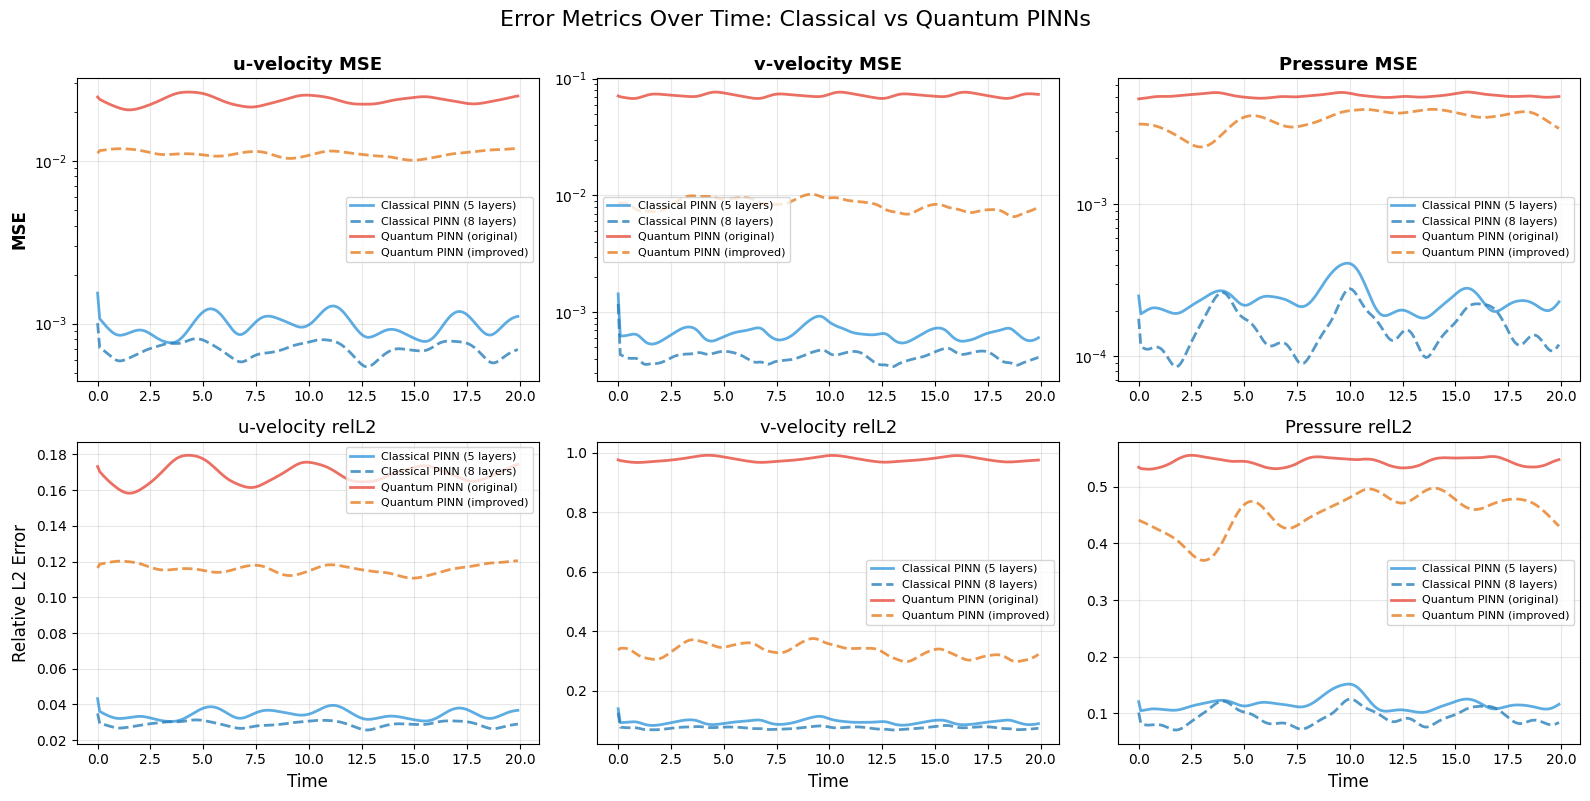

In [27]:
# Error Metrics vs Time

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

colors = {
    'Classical PINN (5 layers)': '#3498db',
    'Classical PINN (8 layers)': '#2980b9',
    'Quantum PINN (original)': '#e74c3c',
    'Quantum PINN (improved)': '#e67e22',
    'Quantum PINN (data reup)': '#9b59b6'
}

linestyles = {
    'Classical PINN (5 layers)': '-',
    'Classical PINN (8 layers)': '--',
    'Quantum PINN (original)': '-',
    'Quantum PINN (improved)': '--',
    'Quantum PINN (data reup)': '-.'
}

# MSE plots
for name, result in results.items():
    metrics = result['time_metrics']
    t = metrics['t']
    
    axes[0, 0].plot(t, metrics['mse_u'], label=name, 
                    color=colors.get(name, 'gray'), 
                    linestyle=linestyles.get(name, '-'),
                    linewidth=2, alpha=0.8)
    axes[0, 1].plot(t, metrics['mse_v'], label=name, 
                    color=colors.get(name, 'gray'),
                    linestyle=linestyles.get(name, '-'),
                    linewidth=2, alpha=0.8)
    axes[0, 2].plot(t, metrics['mse_p'], label=name, 
                    color=colors.get(name, 'gray'),
                    linestyle=linestyles.get(name, '-'),
                    linewidth=2, alpha=0.8)

axes[0, 0].set_ylabel('MSE', fontsize=12, fontweight='bold')
axes[0, 0].set_title('u-velocity MSE', fontsize=13, fontweight='bold')
axes[0, 1].set_title('v-velocity MSE', fontsize=13, fontweight='bold')
axes[0, 2].set_title('Pressure MSE', fontsize=13, fontweight='bold')

for ax in axes[0]:
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

# Relative L2 plots
for name, result in results.items():
    metrics = result['time_metrics']
    t = metrics['t']
    
    axes[1, 0].plot(t, metrics['relL2_u'], label=name, 
                    color=colors.get(name, 'gray'),
                    linestyle=linestyles.get(name, '-'),
                    linewidth=2, alpha=0.8)
    axes[1, 1].plot(t, metrics['relL2_v'], label=name, 
                    color=colors.get(name, 'gray'),
                    linestyle=linestyles.get(name, '-'),
                    linewidth=2, alpha=0.8)
    axes[1, 2].plot(t, metrics['relL2_p'], label=name, 
                    color=colors.get(name, 'gray'),
                    linestyle=linestyles.get(name, '-'),
                    linewidth=2, alpha=0.8)

axes[1, 0].set_xlabel('Time', fontsize=12)
axes[1, 1].set_xlabel('Time', fontsize=12)
axes[1, 2].set_xlabel('Time', fontsize=12)
axes[1, 0].set_ylabel('Relative L2 Error', fontsize=12)
axes[1, 0].set_title('u-velocity relL2', fontsize=13)
axes[1, 1].set_title('v-velocity relL2', fontsize=13)
axes[1, 2].set_title('Pressure relL2', fontsize=13)

for ax in axes[1]:
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

plt.suptitle('Error Metrics Over Time: Classical vs Quantum PINNs', 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

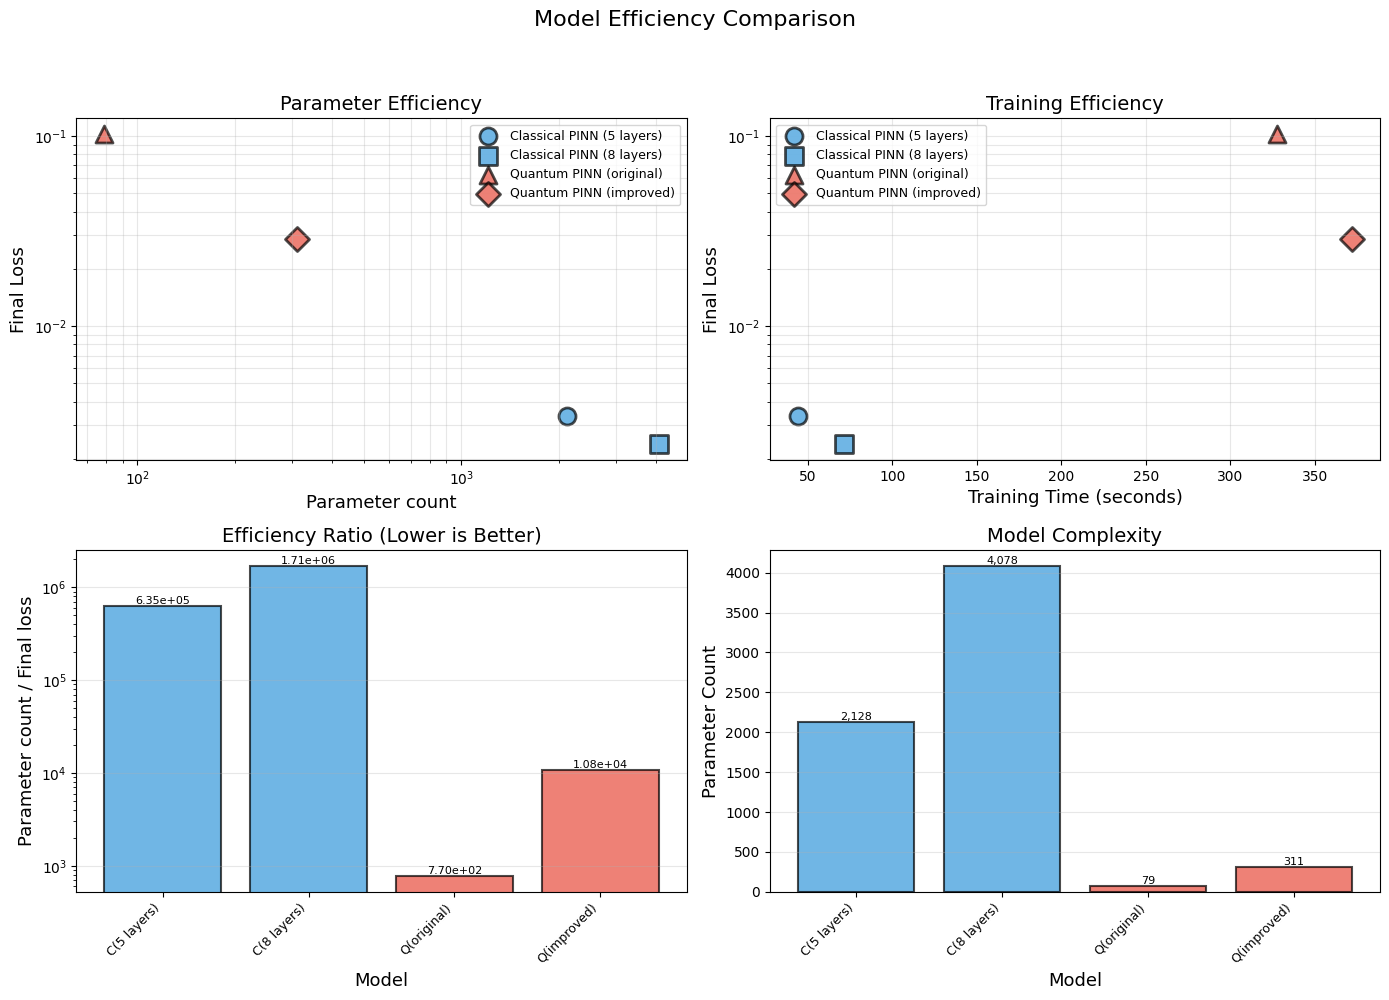

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

models = list(results.keys())
params_list = [results[m]['n_params'] for m in models]
loss_list = [results[m]['metrics']['total'] for m in models]
time_list = [results[m]['train_time'] for m in models]
types = [results[m]['type'] for m in models]

# Assign fixed markers for each model (by name)
marker_map = {
    'Classical PINN (5 layers)': 'o',
    'Classical PINN (8 layers)': 's',
    'Quantum PINN (original)': '^',
    'Quantum PINN (improved)': 'D'
}
markers = [marker_map[m] for m in models]

# Color by type
colors_by_type = ['#3498db' if t == 'classical' else '#e74c3c' for t in types]

# Top-Left: Parameters vs Loss
for i, (model, params, loss, marker, color) in enumerate(zip(models, params_list, loss_list, markers, colors_by_type)):
    axes[0].scatter(params, loss, s=150, c=[color], marker=marker, 
                   alpha=0.7, edgecolors='black', linewidth=2, label=model)
axes[0].set_xlabel('Parameter count', fontsize=13)
axes[0].set_ylabel('Final Loss', fontsize=13)
axes[0].set_title('Parameter Efficiency', fontsize=14)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3, which='both')
axes[0].legend(fontsize=9, loc='best')

# Top-Right: Training Time vs Loss
for i, (model, time, loss, marker, color) in enumerate(zip(models, time_list, loss_list, markers, colors_by_type)):
    axes[1].scatter(time, loss, s=150, c=[color], marker=marker,
                   alpha=0.7, edgecolors='black', linewidth=2, label=model)
axes[1].set_xlabel('Training Time (seconds)', fontsize=13)
axes[1].set_ylabel('Final Loss', fontsize=13)
axes[1].set_title('Training Efficiency', fontsize=14)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend(fontsize=9, loc='best')

# Bottom-Left: Parameter/Loss Ratio (Bar Chart)
efficiency_ratios = [params / max(loss, 1e-10) for params, loss in zip(params_list, loss_list)]
x_pos = np.arange(len(models))
bars = axes[2].bar(x_pos, efficiency_ratios, color=colors_by_type, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[2].set_xlabel('Model', fontsize=13)
axes[2].set_ylabel('Parameter count / Final loss', fontsize=13)
axes[2].set_title('Efficiency Ratio (Lower is Better)', fontsize=14)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([m.replace('PINN ', '').replace('Quantum ', 'Q').replace('Classical ', 'C') 
                         for m in models], rotation=45, ha='right', fontsize=9)
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3, axis='y')
for bar, ratio in zip(bars, efficiency_ratios):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{ratio:.2e}', ha='center', va='bottom', fontsize=8)

# Bottom-Right: Parameter Count Comparison (Bar Chart)
bars = axes[3].bar(x_pos, params_list, color=colors_by_type, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[3].set_xlabel('Model', fontsize=13)
axes[3].set_ylabel('Parameter Count', fontsize=13)
axes[3].set_title('Model Complexity', fontsize=14)
axes[3].set_xticks(x_pos)
axes[3].set_xticklabels([m.replace('PINN ', '').replace('Quantum ', 'Q').replace('Classical ', 'C') 
                         for m in models], rotation=45, ha='right', fontsize=9)
axes[3].grid(True, alpha=0.3, axis='y')
for bar, params in zip(bars, params_list):
    height = bar.get_height()
    axes[3].text(bar.get_x() + bar.get_width()/2., height,
                f'{params:,}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Model Efficiency Comparison', fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [53]:
# Print efficiency summary
print("EFFICIENCY RANKINGS")

# Sort by different metrics
print("\n By Final Loss (lower is better):")
sorted_by_loss = sorted(results.items(), key=lambda x: x[1]['metrics']['total'])
for i, (name, result) in enumerate(sorted_by_loss, 1):
    print(f"  {i}. {name:<30} Loss: {result['metrics']['total']:.6e}")

print("\n By Parameters/Loss Ratio (lower is better):")
sorted_by_eff = sorted(results.items(), 
                       key=lambda x: x[1]['n_params'] / max(x[1]['metrics']['total'], 1e-10))
for i, (name, result) in enumerate(sorted_by_eff, 1):
    ratio = result['n_params'] / max(result['metrics']['total'], 1e-10)
    print(f"  {i}. {name:<30} Ratio: {ratio:.2e}")

print("\n By Training Time (lower is better):")
sorted_by_time = sorted(results.items(), key=lambda x: x[1]['train_time'])
for i, (name, result) in enumerate(sorted_by_time, 1):
    print(f"  {i}. {name:<30} Time: {result['train_time']:.2f}s")

EFFICIENCY RANKINGS

 By Final Loss (lower is better):
  1. Classical PINN (8 layers)      Loss: 2.382573e-03
  2. Classical PINN (5 layers)      Loss: 3.351090e-03
  3. Quantum PINN (improved)        Loss: 2.885629e-02
  4. Quantum PINN (original)        Loss: 1.026470e-01

 By Parameters/Loss Ratio (lower is better):
  1. Quantum PINN (original)        Ratio: 7.70e+02
  2. Quantum PINN (improved)        Ratio: 1.08e+04
  3. Classical PINN (5 layers)      Ratio: 6.35e+05
  4. Classical PINN (8 layers)      Ratio: 1.71e+06

 By Training Time (lower is better):
  1. Classical PINN (5 layers)      Time: 43.88s
  2. Classical PINN (8 layers)      Time: 71.46s
  3. Quantum PINN (original)        Time: 327.90s
  4. Quantum PINN (improved)        Time: 372.27s


In [23]:
# Helper Functions for Vorticity Visualization

def _grid_helpers(data):
    """Precompute grid reshaping helpers"""
    X_star = np.asarray(data["X_star"])
    x_unique = np.asarray(data["x_unique"])
    y_unique = np.asarray(data["y_unique"])
    Nx, Ny = int(data["Nx"]), int(data["Ny"])
    
    # Map points to grid indices
    x_to_ix = {float(x): i for i, x in enumerate(x_unique)}
    y_to_iy = {float(y): i for i, y in enumerate(y_unique)}
    ix = np.array([x_to_ix[float(xx)] for xx in X_star[:, 0]], dtype=int)
    iy = np.array([y_to_iy[float(yy)] for yy in X_star[:, 1]], dtype=int)
    
    # Sorting permutation
    perm = np.lexsort((ix, iy))
    return {"perm": perm, "xg": x_unique, "yg": y_unique, "Nx": Nx, "Ny": Ny}

def _vec_to_grid(vecN, helpers):
    """Reshape length-N vector to (Ny, Nx) grid"""
    Ny, Nx = helpers["Ny"], helpers["Nx"]
    perm = helpers["perm"]
    return np.asarray(vecN)[perm].reshape(Ny, Nx)

def _vorticity_from_uv(u_grid, v_grid, xg, yg):
    """Compute vorticity: ω = ∂v/∂x - ∂u/∂y"""
    dv_dy, dv_dx = np.gradient(v_grid, yg, xg, edge_order=2)
    du_dy, du_dx = np.gradient(u_grid, yg, xg, edge_order=2)
    return dv_dx - du_dy

def get_vorticity_at_time(params, data, t_idx, net_fn, helpers):
    """Get ground truth and predicted vorticity grids at time t_idx"""
    N = int(data["N"])
    X_star = data["X_star"]
    t_val = float(data["t_star"][t_idx, 0])
    
    # Ground truth
    u_true = data["U_star"][..., t_idx][:, 0]
    v_true = data["U_star"][..., t_idx][:, 1]
    
    # Predictions
    xyt = np.hstack([X_star, np.full((N, 1), t_val)]).astype(np.float32)
    u_pred, v_pred, _ = uvp_batch(params, jnp.asarray(xyt), net_fn)
    u_pred = np.asarray(u_pred)
    v_pred = np.asarray(v_pred)
    
    # Convert to grids
    u_true_g = _vec_to_grid(u_true, helpers)
    v_true_g = _vec_to_grid(v_true, helpers)
    u_pred_g = _vec_to_grid(u_pred, helpers)
    v_pred_g = _vec_to_grid(v_pred, helpers)
    
    # Compute vorticity
    xg, yg = helpers["xg"], helpers["yg"]
    vort_true = _vorticity_from_uv(u_true_g, v_true_g, xg, yg)
    vort_pred = _vorticity_from_uv(u_pred_g, v_pred_g, xg, yg)
    
    return vort_true, vort_pred

print("Vorticity computation helpers defined ✓")

Vorticity computation helpers defined ✓


In [34]:
# Animated Comparisons (Best Models)

def animate_multi_comparison(results_dict, data, helpers, t_indices=None, interval=100):
    """Create animated comparison of multiple models"""
    if t_indices is None:
        t_indices = list(range(0, int(data["T"]), max(1, int(data["T"]//50))))
    
    xg, yg = helpers["xg"], helpers["yg"]
    n_models = len(results_dict)
    
    # Compute global color limits
    vmin, vmax = np.inf, -np.inf
    for ti in t_indices:
        for name, result in results_dict.items():
            vort_true, vort_pred = get_vorticity_at_time(result['params'], data, ti, 
                                                         result['net_fn'], helpers)
            vmin = min(vmin, vort_true.min(), vort_pred.min())
            vmax = max(vmax, vort_true.max(), vort_pred.max())
    
    # Create figure with ground truth + all models
    fig, axes = plt.subplots(1, n_models + 1, figsize=(5*(n_models+1), 4), 
                             constrained_layout=True)
    
    # Initialize with first frame
    ti_0 = t_indices[0]
    vort_true_0, _ = get_vorticity_at_time(
        list(results_dict.values())[0]['params'], data, ti_0,
        list(results_dict.values())[0]['net_fn'], helpers
    )
    
    # Ground truth
    im0 = axes[0].imshow(vort_true_0, origin='lower', cmap='RdBu_r', 
                         vmin=vmin, vmax=vmax,
                         extent=[xg.min(), xg.max(), yg.min(), yg.max()])
    axes[0].set_title('Ground Truth', fontsize=12)
    axes[0].set_xlabel('x', fontsize=10)
    axes[0].set_ylabel('y', fontsize=10)
    
    # All model predictions
    images = [im0]
    for i, (name, result) in enumerate(results_dict.items(), 1):
        _, vort_pred_0 = get_vorticity_at_time(result['params'], data, ti_0,
                                               result['net_fn'], helpers)
        im = axes[i].imshow(vort_pred_0, origin='lower', cmap='RdBu_r',
                           vmin=vmin, vmax=vmax,
                           extent=[xg.min(), xg.max(), yg.min(), yg.max()])
        short_name = name.replace('PINN ', '').replace('Quantum ', 'Q').replace('Classical ', 'C')
        axes[i].set_title(short_name, fontsize=12)
        axes[i].set_xlabel('x', fontsize=10)
        images.append(im)
    
    cbar = fig.colorbar(images[-1], ax=axes, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label('Vorticity ω', fontsize=12)
    
    def update(frame_idx):
        ti = t_indices[frame_idx]
        t_val = float(data["t_star"][ti, 0])
        
        # Update ground truth
        vort_true, _ = get_vorticity_at_time(
            list(results_dict.values())[0]['params'], data, ti,
            list(results_dict.values())[0]['net_fn'], helpers
        )
        images[0].set_data(vort_true)
        
        # Update all models
        for i, (name, result) in enumerate(results_dict.items(), 1):
            _, vort_pred = get_vorticity_at_time(result['params'], data, ti,
                                                 result['net_fn'], helpers)
            images[i].set_data(vort_pred)
        
        fig.suptitle(f'vorticity @ t = {t_val:.4f} (step {ti}/{data["T"]})',
                     fontsize=15)
        
        return images
    
    anim = animation.FuncAnimation(fig, update, frames=len(t_indices), 
                                   interval=interval, blit=False)
    plt.close(fig)   # prevents auto-display of the plain figure
    return fig, anim

# Create animation with all models
print("Creating animation with all models (this may take a moment)...")
t_indices = list(range(0, int(data["T"]), max(1, int(data["T"]//40))))

fig_anim, anim = animate_multi_comparison(
    results, data, helpers,
    t_indices=t_indices,
    interval=100
)

print("✓ Animation created")
HTML(anim.to_jshtml())

Creating animation with all models (this may take a moment)...
✓ Animation created


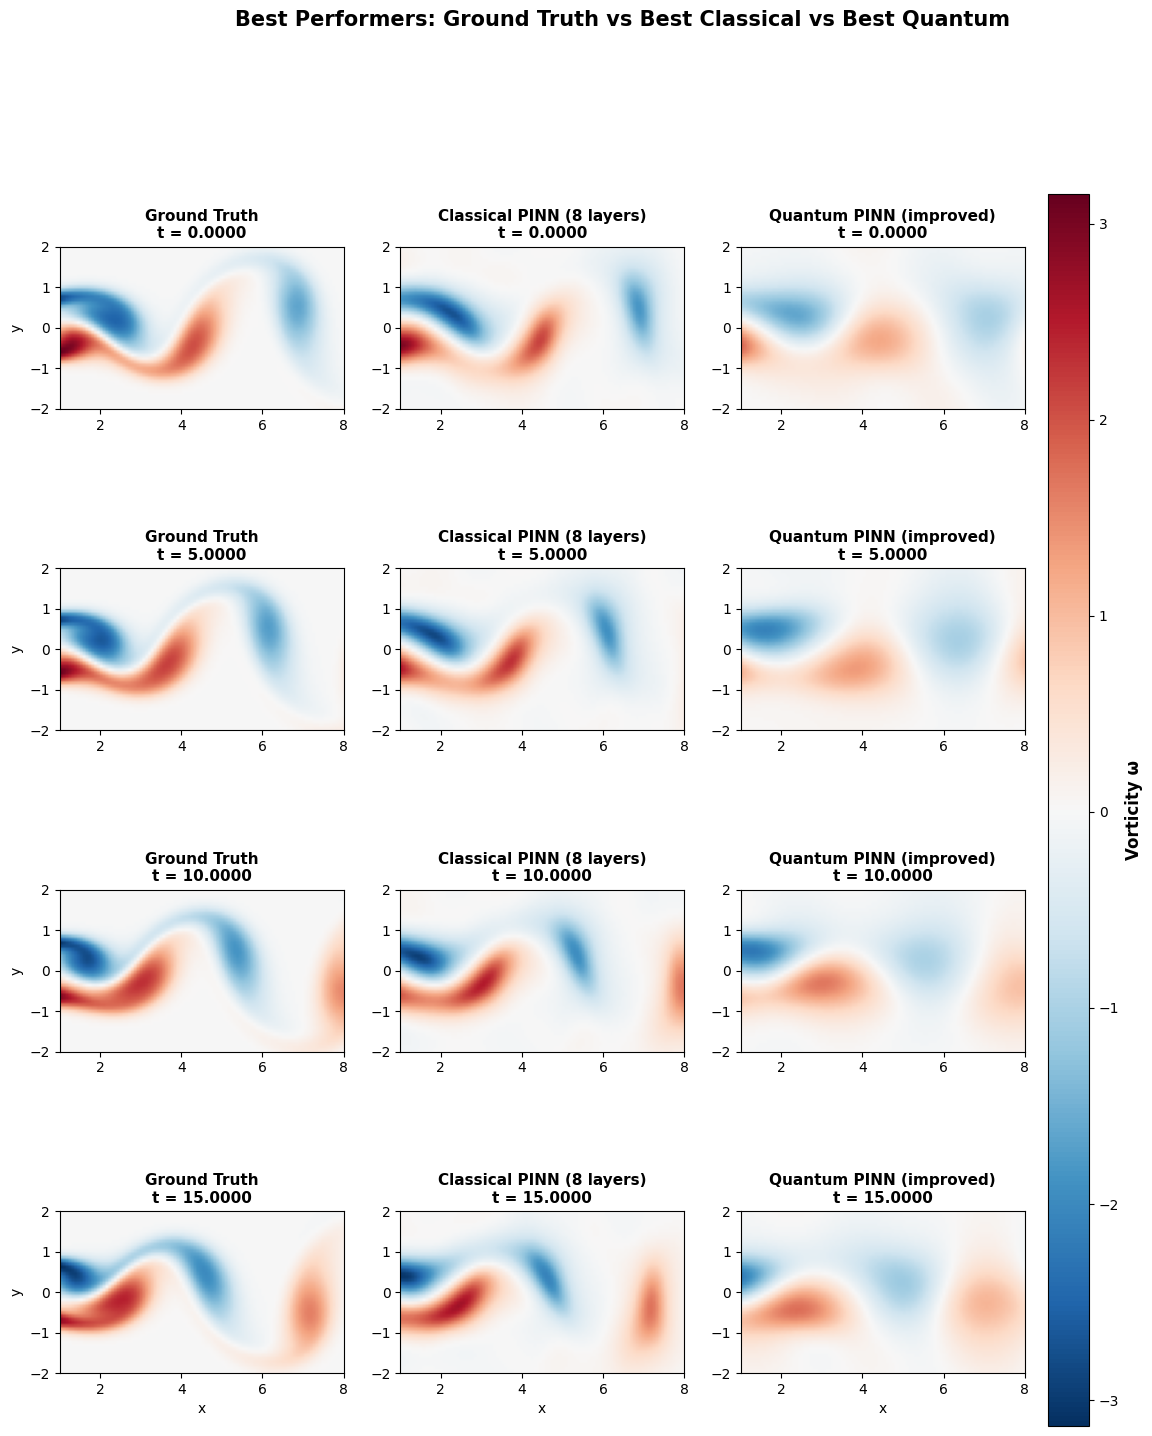

In [24]:
# Vorticity Snapshot Comparison (Best Models)

helpers = _grid_helpers(data)
xg, yg = helpers["xg"], helpers["yg"]

# Select best classical and best quantum models by loss
classical_models = {k: v for k, v in results.items() if v['type'] == 'classical'}
quantum_models = {k: v for k, v in results.items() if v['type'] == 'quantum'}

best_classical = min(classical_models.items(), key=lambda x: x[1]['metrics']['total'])
best_quantum = min(quantum_models.items(), key=lambda x: x[1]['metrics']['total'])

# Select time snapshots
t_snapshots = [0, int(data["T"]//4), int(data["T"]//2), int(3*data["T"]//4)]

fig, axes = plt.subplots(len(t_snapshots), 3, figsize=(15, 4*len(t_snapshots)))

# Compute global vmin/vmax
vmin, vmax = np.inf, -np.inf
for ti in t_snapshots:
    vort_true, _ = get_vorticity_at_time(best_classical[1]['params'], data, ti, 
                                         best_classical[1]['net_fn'], helpers)
    _, vort_classical = get_vorticity_at_time(best_classical[1]['params'], data, ti,
                                              best_classical[1]['net_fn'], helpers)
    _, vort_quantum = get_vorticity_at_time(best_quantum[1]['params'], data, ti,
                                            best_quantum[1]['net_fn'], helpers)
    vmin = min(vmin, vort_true.min(), vort_classical.min(), vort_quantum.min())
    vmax = max(vmax, vort_true.max(), vort_classical.max(), vort_quantum.max())

# Plot
for row, ti in enumerate(t_snapshots):
    t_val = float(data["t_star"][ti, 0])
    
    # Ground truth
    vort_true, _ = get_vorticity_at_time(best_classical[1]['params'], data, ti,
                                         best_classical[1]['net_fn'], helpers)
    im0 = axes[row, 0].imshow(vort_true, origin='lower', cmap='RdBu_r', 
                              vmin=vmin, vmax=vmax,
                              extent=[xg.min(), xg.max(), yg.min(), yg.max()])
    axes[row, 0].set_title(f'Ground Truth\nt = {t_val:.4f}', fontsize=11, fontweight='bold')
    axes[row, 0].set_ylabel('y', fontsize=10)
    
    # Best Classical
    _, vort_classical = get_vorticity_at_time(best_classical[1]['params'], data, ti,
                                              best_classical[1]['net_fn'], helpers)
    im1 = axes[row, 1].imshow(vort_classical, origin='lower', cmap='RdBu_r',
                              vmin=vmin, vmax=vmax,
                              extent=[xg.min(), xg.max(), yg.min(), yg.max()])
    axes[row, 1].set_title(f'{best_classical[0]}\nt = {t_val:.4f}', fontsize=11, fontweight='bold')
    
    # Best Quantum
    _, vort_quantum = get_vorticity_at_time(best_quantum[1]['params'], data, ti,
                                            best_quantum[1]['net_fn'], helpers)
    im2 = axes[row, 2].imshow(vort_quantum, origin='lower', cmap='RdBu_r',
                              vmin=vmin, vmax=vmax,
                              extent=[xg.min(), xg.max(), yg.min(), yg.max()])
    axes[row, 2].set_title(f'{best_quantum[0]}\nt = {t_val:.4f}', fontsize=11, fontweight='bold')
    
    # X-labels on bottom row
    if row == len(t_snapshots) - 1:
        for col in range(3):
            axes[row, col].set_xlabel('x', fontsize=10)

# Colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='vertical', pad=0.02, aspect=30)
cbar.set_label('Vorticity ω', fontsize=12, fontweight='bold')

plt.suptitle(f'Best Performers: Ground Truth vs Best Classical vs Best Quantum', 
             fontsize=15, fontweight='bold', y=0.995)
#plt.tight_layout()
plt.show()

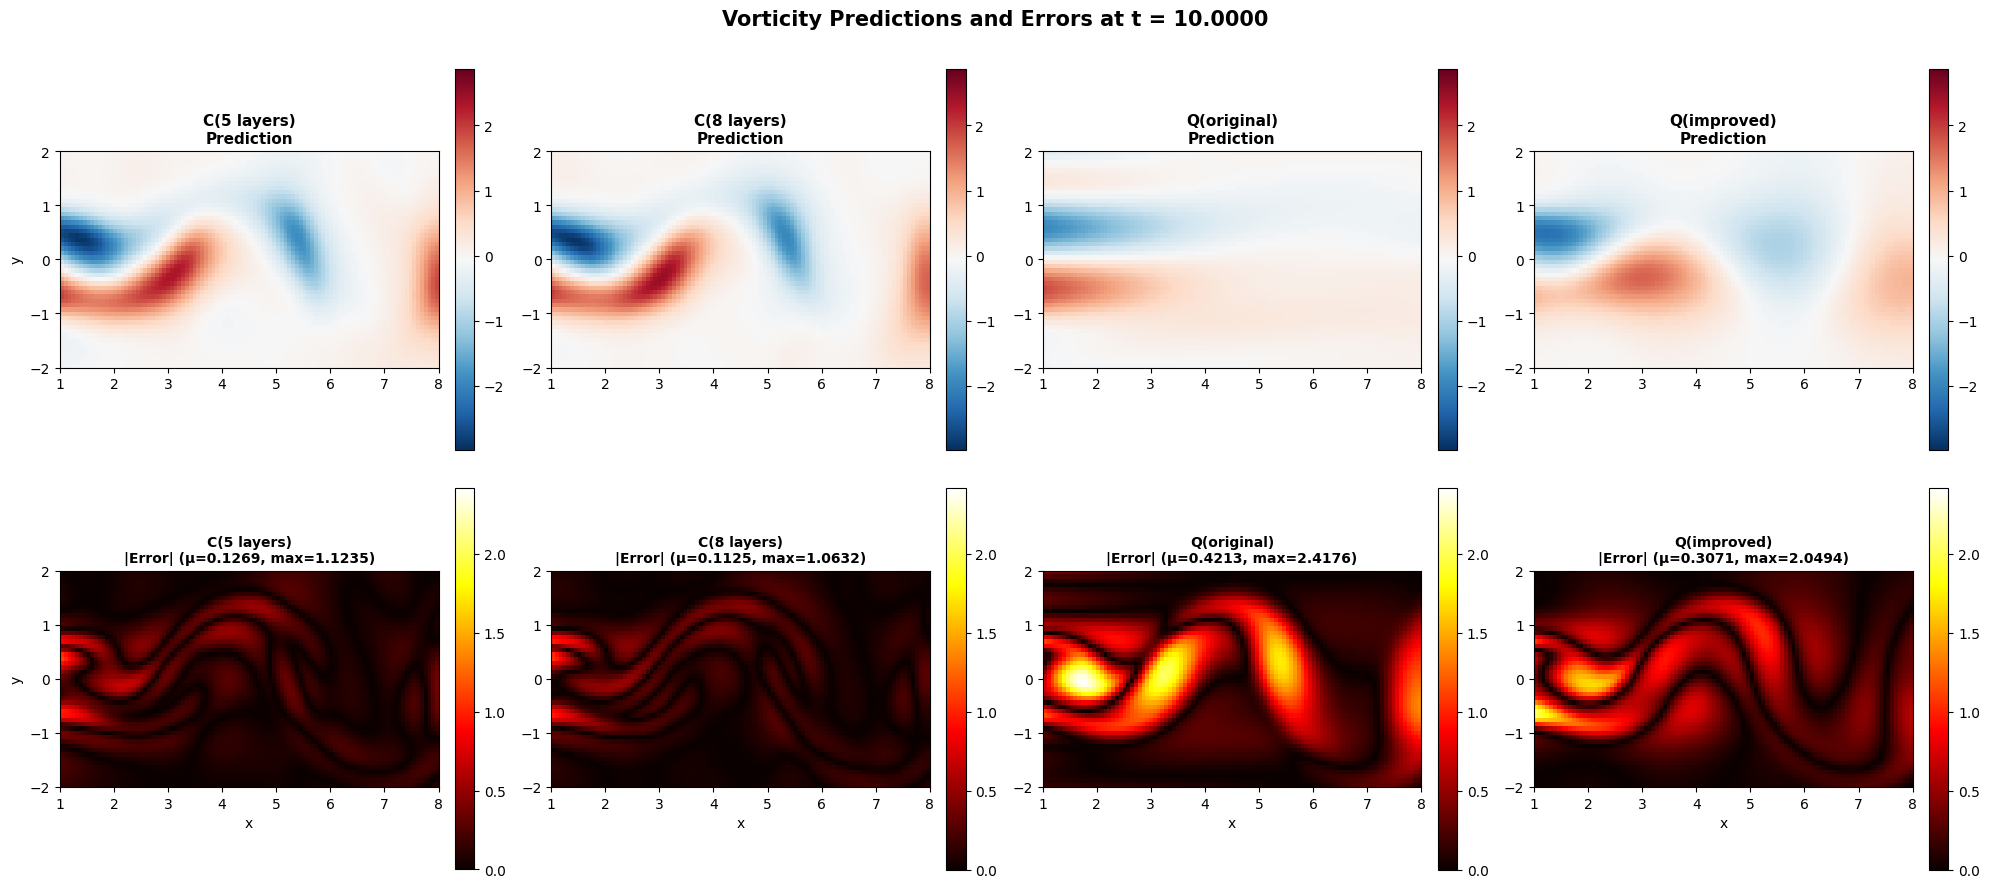


ERROR STATISTICS AT t = 10.0000

Classical PINN (5 layers):
  Mean Error:   0.126928
  Std Error:    0.133130
  Max Error:    1.123529
  Min Error:    0.000008
  Median Error: 0.084721

Classical PINN (8 layers):
  Mean Error:   0.112522
  Std Error:    0.122943
  Max Error:    1.063210
  Min Error:    0.000006
  Median Error: 0.075733

Quantum PINN (original):
  Mean Error:   0.421330
  Std Error:    0.478510
  Max Error:    2.417588
  Min Error:    0.000088
  Median Error: 0.205875

Quantum PINN (improved):
  Mean Error:   0.307066
  Std Error:    0.302524
  Max Error:    2.049392
  Min Error:    0.000020
  Median Error: 0.213047


In [25]:
# Vorticity Error Heatmaps - All Models

# Select middle timestep
t_idx = int(data["T"] // 2)
t_val = float(data["t_star"][t_idx, 0])

n_models = len(results)
fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 9))

if n_models == 1:
    axes = axes.reshape(2, 1)

# Get ground truth
vort_true, _ = get_vorticity_at_time(
    list(results.values())[0]['params'], data, t_idx, 
    list(results.values())[0]['net_fn'], helpers
)

# Compute all predictions and errors
predictions = {}
errors = {}
vmax_err = 0

for name, result in results.items():
    _, vort_pred = get_vorticity_at_time(result['params'], data, t_idx,
                                         result['net_fn'], helpers)
    predictions[name] = vort_pred
    errors[name] = np.abs(vort_pred - vort_true)
    vmax_err = max(vmax_err, errors[name].max())

# Plot predictions (top row)
vmin_vort, vmax_vort = vort_true.min(), vort_true.max()
for col, (name, vort_pred) in enumerate(predictions.items()):
    im = axes[0, col].imshow(vort_pred, origin='lower', cmap='RdBu_r',
                             vmin=vmin_vort, vmax=vmax_vort,
                             extent=[xg.min(), xg.max(), yg.min(), yg.max()])
    short_name = name.replace('PINN ', '').replace('Quantum ', 'Q').replace('Classical ', 'C')
    axes[0, col].set_title(f'{short_name}\nPrediction', fontsize=11, fontweight='bold')
    if col == 0:
        axes[0, col].set_ylabel('y', fontsize=10)
    fig.colorbar(im, ax=axes[0, col], fraction=0.046, pad=0.04)

# Plot errors (bottom row)
for col, (name, error) in enumerate(errors.items()):
    im = axes[1, col].imshow(error, origin='lower', cmap='hot',
                             vmin=0, vmax=vmax_err,
                             extent=[xg.min(), xg.max(), yg.min(), yg.max()])
    short_name = name.replace('PINN ', '').replace('Quantum ', 'Q').replace('Classical ', 'C')
    axes[1, col].set_title(f'{short_name}\n|Error| (μ={error.mean():.4f}, max={error.max():.4f})',
                          fontsize=10, fontweight='bold')
    axes[1, col].set_xlabel('x', fontsize=10)
    if col == 0:
        axes[1, col].set_ylabel('y', fontsize=10)
    fig.colorbar(im, ax=axes[1, col], fraction=0.046, pad=0.04)

plt.suptitle(f'Vorticity Predictions and Errors at t = {t_val:.4f}', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print error statistics
print("\n" + "="*70)
print("ERROR STATISTICS AT t = {:.4f}".format(t_val))
print("="*70)
for name, error in errors.items():
    print(f"\n{name}:")
    print(f"  Mean Error:   {error.mean():.6f}")
    print(f"  Std Error:    {error.std():.6f}")
    print(f"  Max Error:    {error.max():.6f}")
    print(f"  Min Error:    {error.min():.6f}")
    print(f"  Median Error: {np.median(error):.6f}")

# Real Quantum Computers vs Classical Simulations

For a quantum circuit acting on **n qubits**, the difference in runtime scaling comes from how the state is represented and updated:

#### **Actual Quantum Hardware**
- Each gate acts only on **1 or 2 qubits**.
- Applying a physical gate takes (roughly) a **constant amount of time**, independent of `n`.
- **Total runtime:**  
  $ \text{runtime} \approx (\#\text{gates}) \times (\text{time per gate}) $

#### **Classical Simulation**
- The full quantum state has **\(2^n\)** complex amplitudes.
- Simulating *any* gate requires updating **all \(2^n\)** amplitudes.
- **Runtime per gate:** proportional to \(2^n\).
- **Total runtime:**  
  $ \text{runtime} \approx (\#\text{gates}) \times 2^n $

#### **Key Insight**
As the number of qubits grows, a classical simulation becomes **exponentially slower**, because it must explicitly manipulate the entire state vector.  
A real quantum device, on the other hand, *is* the state, so executing the circuit ideally scales only with the number of gates—not with \(2^n\).